# Importing Necessary Libraries

In [1]:
%matplotlib notebook

import math
import time
from collections import deque

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


# Load up the data
## Google stock prices dataset
<br>Data from [Yahoo Finance](https://finance.yahoo.com/) and it contains **AMD** and **GOOGLE** daily historical price, starting from 2009 to 2018.
<br>You can find the data [here](https://www.kaggle.com/gunhee/amdgoogle)

In [2]:
google_df = pd.read_csv("GOOGLE.csv")
google_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
1,2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2,2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
3,2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
4,2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100


In [3]:
google_df = google_df[['Date','Close']]
google_df.head()

,Date,Close
0,2009-05-22,196.946945
1,2009-05-26,202.382385
2,2009-05-27,202.982986
3,2009-05-28,205.405411
4,2009-05-29,208.823822


Drop the date column.

In [4]:
google_df.drop(['Date'], axis=1, inplace=True)
google_df.head()

,Close
0,196.946945
1,202.382385
2,202.982986
3,205.405411
4,208.823822


In [5]:
google_df.rename(columns={'Close':'Price'}, inplace=True)
google_df.head()

,Price
0,196.946945
1,202.382385
2,202.982986
3,205.405411
4,208.823822


Drop Nan values.

In [6]:
print("Before dropping Nan values: ", len(google_df))

Before dropping Nan values:  2335


In [7]:
google_df.dropna(inplace=True)

In [8]:
print("After dropping Nan values: ", len(google_df))

After dropping Nan values:  2335


## Plot the data

<IPython.core.display.Javascript object>


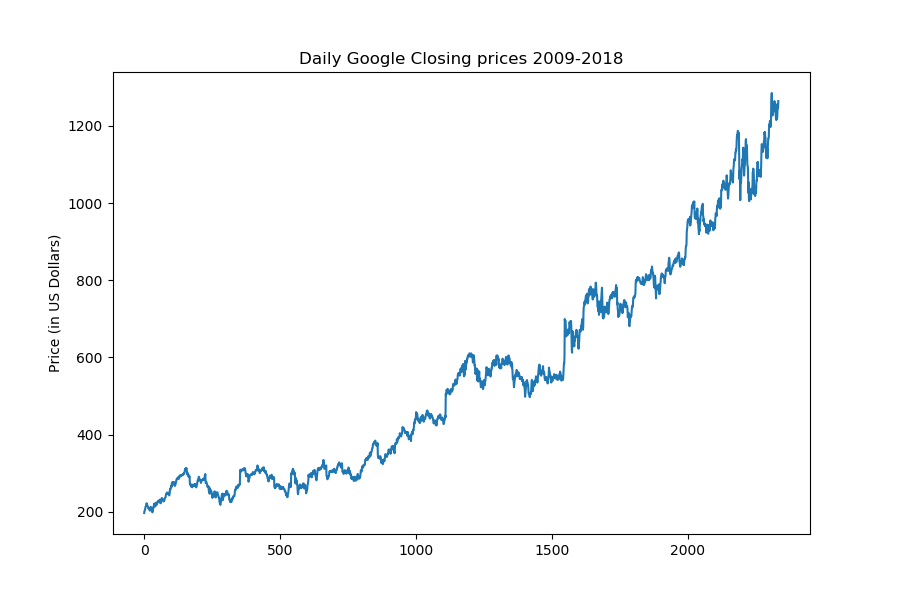

In [9]:
plt.figure(figsize=(9,6))
plt.plot(google_df.index, google_df)
plt.title("Daily Google Closing prices 2009-2018")
plt.ylabel("Price (in US Dollars)")
plt.show()

# Data Preprocessing

These functions will be used to scale, generate sequences, and split our sequential data in order to prepare it for input to an LSTM Keras model.

This function is for scaling the data.
<br>**Note:** we need to scale because if we fit the model on unscaled data that has a wide range of values, then it is possible for large inputs to slow down the learning and convergence of our network and in some cases prevent the network from effectively learning your problem.

In [10]:
def scale_data(input_3d_array):
    """
    This function transforms the values of a 3D numpy array using MinMaxScaler from sklearn.model_selection
    """
    original_shape = input_3d_array.shape
    # Reshaping the the array in order to make it 2-Dimensional array
    # since fit_transform function accepts only 2D array as an input parameter.
    input_3d_array = input_3d_array.reshape(input_3d_array.shape[0],input_3d_array.shape[1])
    # Transforming the values.
    input_3d_array = min_max_scaler.fit_transform(input_3d_array)
    # Reshaping the array back to its original shape.
    input_3d_array = input_3d_array.reshape(original_shape)
    
    return input_3d_array

This function will be used to generate input sequences which consists of (X,y) arrays, where:
<br> X : the prices of the days preceding the target day (the day that we want to predict the price for).
<br> y : the price on target day.

In [11]:
def preprocess_data(data_array, window):
    """
    This method takes a numpy array as input, and returns X,y numpy arrays as the output.
    N = len(data)
    X (data_array) = shape(N-window,window,1)
    y = shape(N-window,1)
    """
    X = []
    y = []
    SEQ_LEN = window
    # the prices of a number of squential days equal to the window parameter
    prev_days = deque(maxlen=SEQ_LEN)
    for index,item in enumerate(data_array[:-1]):
        prev_days.append(item)
        if len(prev_days) == SEQ_LEN:
            X.append(np.array(prev_days))
            y.append(data_array[index+1])
    
    return np.array(X), np.array(y)

This function will be used for splitting the data into training, testing and validation sets.

In [12]:
def split_data(X_main, y_main, split_test_and_val=0.2):
    
    """
    This function returns training, validation, and testing data based on the wanted split size. as follows:
    X_test, X_val, y_test, y_val
    The split validation and the test data are going to have size of (split_size) and the rest of the data
    is going to categorized under training
    : X_main: inputs
    : y_main: targets
    : split_size: float ex. 0.2 means 10% for testing and 10% for validation and 80% for training
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X_main, y_main, test_size=split_test_and_val)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

# Saving some input samples to test the trained models

We are going to train **6 models** in order to experiment the different resutls and pick out what is best. Concretely, these are the characteristics that we are going to build the models on:
* Save **100** input samples from the last part of the data. **(70% training data, 15% validation data,15% testing data)**
* Save **100** input samples. **(50% training, 25% validation, 25% testing)**
* Save **1000** input samples **(70% training, 15% validation, 15% testing)**
* Save **1000** input samples **(50% training, 25% validation, 25% testing)**
* Save **2000** input samples **(70% training, 15% validation, 15% testing)**
* Save **2000** input samples **(50% training, 25% validation, 25% testing)**

Using MinMaxScaler provided by Scikit-learn in order to scale the data into the range (0,1).

In [13]:
min_max_scaler = MinMaxScaler()
min_max_scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

The following method will be used for creating the input and output sample arrays that are going to be used later for testing
the model:

In [14]:
def create_input_and_output_sample(df, input_sample_length, window):
    """
    This method takes a dataframe, an input sample length which is the number of days that we want to predict from the last
    part of the given dataframe, and window which is the number of consecutive days that we will look at before each day
    that we will predict.
    """
    # take the last necessary part of the dataframe
    index = input_sample_length + window
    df = df[-index:]
    # scale the data
    scaled_df = scale_data(df.values)
    # getting the input_sample and output_sample
    X, y = preprocess_data(scaled_df, window)
    
    print(f"input sample length: {input_sample_length}, window: {window}")
    print(f"Shape of X: {X.shape}, shape of y: {y.shape}")
    
    return X, y

Extract the (X,y) Numpy arrays from the last part of the data to use it to evaluate the the models.

In [16]:
X_test_sample_100, y_test_sample_100 = create_input_and_output_sample(df=google_df, input_sample_length=100, window=10)
X_test_sample_1000, y_test_sample_1000 = create_input_and_output_sample(df=google_df, input_sample_length=1000, window=10)
X_test_sample_2000, y_test_sample_2000 = create_input_and_output_sample(df=google_df, input_sample_length=2000, window=10)

input sample length: 100, window: 10
Shape of X: (100, 10, 1), shape of y: (100, 1)
input sample length: 1000, window: 10
Shape of X: (1000, 10, 1), shape of y: (1000, 1)
input sample length: 2000, window: 10
Shape of X: (2000, 10, 1), shape of y: (2000, 1)


In [17]:
len(google_df)

2335

Let's extract the data that will be used for generating sequences and fitting the model excluding the last 100, 1000, 2000 days respectively. Concretely:
<br>df_100_70 : This data frame will be used to fit (70% training, 30% testing) model with last 100 days excluded from the original data.
<br>df_100_50 : This data frame will be used to fit (50% training, 50% testing) model with last 100 days excluded from the original data.
<br>df_1000_70 : This data frame will be used to fit (70% training, 30% testing) model with last 1000 days excluded from the original data.
<br>df_1000_50 : This data frame will be used to fit (50% training, 50% testing) model with last 1000 days excluded from the original data.
<br>df_2000_70 : This data frame will be used to fit (70% training, 30% testing) model with last 2000 days excluded from the original data.
<br>df_2000_50 : This data frame will be used to fit (50% training, 50% testing) model with last 2000 days excluded from the original data.

In [18]:
df_100_70 = google_df[:-100] # the rest of the data that we are going to use for training and testing
df_100_50 = google_df[:-100] # the rest of the data that we are going to use for training and testing

df_1000_70 = google_df[:-1000] # the rest of the data that we are going to use for training and testing
df_1000_50 = google_df[:-1000] # the rest of the data that we are going to use for training and testing

df_2000_70 = google_df[:-2000] # the rest of the data that we are going to use for training and testing
df_2000_50 = google_df[:-2000] # the rest of the data that we are going to use for training and testing

# Scaling the data

In [19]:
scaled_data_100_70 = scale_data(df_100_70.values)
scaled_data_100_50 = scale_data(df_100_50.values)

scaled_data_1000_70 = scale_data(df_1000_70.values)
scaled_data_1000_50 = scale_data(df_1000_50.values)

scaled_data_2000_70 = scale_data(df_2000_70.values)
scaled_data_2000_50 = scale_data(df_2000_50.values)

This function will be used for generating a list of random number (between a range whose bounds set by the parameters). These numbers will be used to generate X sequences that will be provided as an input for our models.

In [20]:
def generate_random_list_of_delays(size=20,min_range=0,max_range=100):
    
    import random
    result = [random.randint(min_range, max_range) for i in range(size)]
    
    return result

In [21]:
lengths = [54, 94, 33, 68, 59, 86, 27, 94, 92, 87, 76, 63, 20, 28, 43, 98, 75, 10, 13, 17, 72, 67, 89, 72, 39, 68, 9, 54, 13, 57]
print(lengths)

[54, 94, 33, 68, 59, 86, 27, 94, 92, 87, 76, 63, 20, 28, 43, 98, 75, 10, 13, 17, 72, 67, 89, 72, 39, 68, 9, 54, 13, 57]


The following method will be used for generating all the input and output sequences as (X,y) Numpy arrays based on the random lengths generated earlier and storing each (X,y) pair in two separate lists. After that, these lists will be split into training, testing and validation, which in its turn makes up 4 lists, where:
<br>X_train_all: contains all input sequential X Numpy arrays that will be used for training.
<br>X_test_all: contains all input sequential X Numpy arrays that will be used for testing.
<br>X_val_all: contains all input sequential X Numpy arrays that will be used for validation.
<br>y_train_all: contains all output sequential y Numpy arrays that will be used for training.
<br>y_test_all: contains all output sequential y Numpy arrays that will be used for testing.
<br>y_val_all: contains all output sequential y Numpy arrays that will be used for validation.

In [22]:
def generate_input_and_target_lists(scaled_data, lengths, split_size):
    """
    This method takes a scaled pandas dataframe, a list of lengths which represents the window (or the consecutive days) that
    the model is going to use in order to the preidct the next day, and the test size split. It returns the following four 
    lists (each one of these lists is based on its corresponding length of the list of lengths.):
    (X_train_all, X_test_all, y_train_all, y_test_all)
    """
    
    
    X_lists = []
    y_lists = []

    X_train_all = []
    X_test_all = []
    X_val_all = []

    y_train_all = []
    y_test_all = []
    y_val_all = []

    for length in lengths:
    
        X, y = preprocess_data(scaled_data, window=length)
    
        X_lists.append(X)
        y_lists.append(y)
    
        # split data into (train, validatoin, test)
        X_train, X_test, X_val, y_train, y_test, y_val = split_data(X, y, split_test_and_val= split_size)
    
        X_train_all.append(X_train)
        X_test_all.append(X_test) 
        X_val_all.append(X_val)
    
        y_train_all.append(y_train)
        y_test_all.append(y_test)
        y_val_all.append(y_val)
        
    return (X_train_all, X_test_all, X_val_all, y_train_all, y_test_all, y_val_all)

# Generate input and output sequences

**Note:** The following cell may take a while :)

In [23]:
X_train_all_100_70, X_test_all_100_70, X_val_all_100_70, y_train_all_100_70, y_test_all_100_70, y_val_all_100_70 = \
generate_input_and_target_lists(scaled_data= scaled_data_100_70, lengths= lengths, split_size= 0.3)

X_train_all_100_50, X_test_all_100_50, X_val_all_100_50, y_train_all_100_50, y_test_all_100_50, y_val_all_100_50 = \
generate_input_and_target_lists(scaled_data= scaled_data_100_50, lengths= lengths, split_size= 0.5)

X_train_all_1000_70, X_test_all_1000_70, X_val_all_1000_70, y_train_all_1000_70, y_test_all_1000_70, y_val_all_1000_70 = \
generate_input_and_target_lists(scaled_data= scaled_data_1000_70, lengths= lengths, split_size= 0.3)

X_train_all_1000_50, X_test_all_1000_50, X_val_all_1000_50, y_train_all_1000_50, y_test_all_1000_50, y_val_all_1000_50 = \
generate_input_and_target_lists(scaled_data= scaled_data_1000_50, lengths= lengths, split_size= 0.5)

X_train_all_2000_70, X_test_all_2000_70, X_val_all_2000_70, y_train_all_2000_70, y_test_all_2000_70, y_val_all_2000_70 = \
generate_input_and_target_lists(scaled_data= scaled_data_2000_70, lengths= lengths, split_size= 0.3)

X_train_all_2000_50, X_test_all_2000_50, X_val_all_2000_50, y_train_all_2000_50, y_test_all_2000_50, y_val_all_2000_50 = \
generate_input_and_target_lists(scaled_data= scaled_data_2000_50, lengths= lengths, split_size= 0.5)

Some printings to get a feel of the results and make sure that everything has been done correctly.

In [24]:
print("Lengths of the X and y lists (100 input samples extracted from the last part of the data)")
print(len(X_train_all_100_70), len(X_test_all_100_70), len(X_val_all_100_70), len(y_train_all_100_70), \
      len(y_test_all_100_70), len(y_val_all_100_70))
print(len(X_train_all_100_50), len(X_test_all_100_50), len(X_val_all_1000_50), len(X_val_all_100_50), \
      len(y_train_all_100_50), len(y_test_all_100_50), len(y_val_all_1000_50))

print("Lengths of the X and y lists (1000 input samples extracted from the last part of the data)")
print(len(X_train_all_1000_70), len(X_test_all_1000_70), len(X_val_all_1000_70), len(y_train_all_1000_70), \
      len(y_test_all_1000_70), len(y_val_all_1000_70))
print(len(X_train_all_1000_50), len(X_test_all_1000_50), len(X_val_all_1000_50), len(y_train_all_1000_50), \
      len(y_test_all_1000_50), len(y_val_all_1000_50))

print("Lengths of the X and y lists (2000 input samples extracted from the last part of the data)")
print(len(X_train_all_2000_70), len(X_test_all_2000_70), len(X_val_all_2000_70), len(y_train_all_2000_70), \
      len(y_test_all_2000_70), len(y_val_all_2000_70))
print(len(X_train_all_2000_50), len(X_test_all_2000_50), len(X_val_all_2000_50), len(y_train_all_2000_50), \
      len(y_test_all_2000_50), len(y_val_all_2000_50))


print("First sample shape of each list (X_train_shape, X_test_shape, y_train_shape, y_test_shape):")
print(X_train_all_100_70[0].shape, X_test_all_100_70[0].shape, X_val_all_100_70[0].shape, y_train_all_100_70[0].shape, \
      y_test_all_100_70[0].shape, y_val_all_100_70[0].shape)
print(X_train_all_100_50[0].shape, X_test_all_100_50[0].shape, X_val_all_100_70[0].shape, y_train_all_100_50[0].shape, \
      y_test_all_100_50[0].shape, y_val_all_100_50[0].shape)

print(X_train_all_1000_70[0].shape, X_test_all_1000_70[0].shape, X_val_all_1000_70[0].shape, y_train_all_1000_70[0].shape, \
      y_test_all_1000_70[0].shape, y_val_all_1000_70[0].shape)
print(X_train_all_1000_50[0].shape, X_test_all_1000_50[0].shape, X_val_all_1000_50[0].shape, y_train_all_1000_50[0].shape, \
      y_test_all_1000_50[0].shape, y_val_all_1000_50[0].shape)

print(X_train_all_2000_70[0].shape, X_test_all_2000_70[0].shape, X_val_all_2000_70[0].shape, y_train_all_2000_70[0].shape, \
      y_test_all_2000_70[0].shape, y_val_all_2000_70[0].shape)
print(X_train_all_2000_50[0].shape, X_test_all_2000_50[0].shape, X_val_all_2000_50[0].shape, y_train_all_2000_50[0].shape, \
      y_test_all_2000_50[0].shape, y_val_all_2000_50[0].shape)

Lengths of the X and y lists (100 input samples extracted from the last part of the data)
30 30 30 30 30 30
30 30 30 30 30 30 30
Lengths of the X and y lists (1000 input samples extracted from the last part of the data)
30 30 30 30 30 30
30 30 30 30 30 30
Lengths of the X and y lists (2000 input samples extracted from the last part of the data)
30 30 30 30 30 30
30 30 30 30 30 30
First sample shape of each list (X_train_shape, X_test_shape, y_train_shape, y_test_shape):
(1526, 54, 1) (327, 54, 1) (328, 54, 1) (1526, 1) (327, 1) (328, 1)
(1090, 54, 1) (545, 54, 1) (328, 54, 1) (1090, 1) (545, 1) (546, 1)
(896, 54, 1) (192, 54, 1) (193, 54, 1) (896, 1) (192, 1) (193, 1)
(640, 54, 1) (320, 54, 1) (321, 54, 1) (640, 1) (320, 1) (321, 1)
(196, 54, 1) (42, 54, 1) (43, 54, 1) (196, 1) (42, 1) (43, 1)
(140, 54, 1) (70, 54, 1) (71, 54, 1) (140, 1) (70, 1) (71, 1)


## Data visualization functions to compare models visually:

The following method takes the following arguments:
model: a trained Keras LSTM model.
<br>X: a 2-D Numpy array that consists of the input sequences of prices, each item is an input sequence Numpy array that consists of the prices of days preceding each target day.
<br>y: a 1-D Numpy array that consists of the prices of each target day (which comes right after the last day (item) in the corresponding X array).
<br>And, it plots a figure showing the prices and the predictions and it returns the MSE value.

In [25]:
def plot_predictions_and_real_prices_for_one_sample(model, X, y, real_label='Real Prices', predicted_label='Predicted Prices'
                                                    , title=None, xlabel='Days', ylabel='Prices'):
        # mse
    mse = model.evaluate(X, y)
    print(f"MSE: {mse}")
    
    # Range of observations
    n = range(len(y))
    # Predict prices
    y_hat = model.predict(X)
    
    # Plot the results
    #plt.figure(figsize=(10,6))
    plt.figure()
    # Plot the real prices
    plt.plot(n, y,'r',label=real_label)
    # Plot the predicted prices
    plt.plot(n, y_hat,label=predicted_label)
    
    # Naming the axes       
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if title is None:
        # Adding a title to the plot
        window = X.shape[1]
        title = 'Data with a window of ' + str(window)
    #plt.title(f"Last {len(y)} days with their predicted prices")
    plt.title(title)
    
    plt.legend()
    plt.show()
    
    return mse

This function uses the preceding one in order to plot multiple figures for multiple figures, each showing the prices and the predictions. Where the arguemnts are:
<br>model: a trained model.
<br>X_test_all: a 3-D Numpy array, where each item is a 2-D Numpy array that consists of the input sequences of prices, each item is an input sequence Numpy array that consists of the prices of days preceding each target day.
<br>y_test_all: a 2-D Numpy array, where each item is a 1-D Numpy array that consists of the prices of each target day (which comes right after the last day (item) in the corresponding X array). 

In [26]:
def plot_predictions_and_real_prices_for_multiple_samples(model, X_test_all, y_test_all):
    for X, y in zip(X_test_all, y_test_all):
        # title of the plot
        window = X.shape[1]
        title = 'Data with a window of ' + str(window)
        plot_predictions_and_real_prices_for_one_sample(model, X, y, 'Real Prices', 'Predicted Prices', title,
                                                        'Days', 'Prices')

This function takes the following arguments:
<br>model: a trained model. 
<br>X_test_all: a 3-D Numpy array, where each item is a 2-D Numpy array that consists of the input sequences of prices, each item is an input sequence Numpy array that consists of the prices of days preceding each target day. 
<br>y_test_all: a 2-D Numpy array, where each item is a 1-D Numpy array that consists of the prices of each target day (which comes right after the last day (item) in the corresponding X array).
<br>It evaluates the model on each (X,y) pair (where X is 2-D an array from the X_test_all array and y is its corresponding 1-D array) and computes MSE and appends it to the a list, which will be returned afterwards. 

In [27]:
def mse_list(model, X_test_all, y_test_all, lenghts):
    mse_list = []
    for X, y in zip(X_test_all, y_test_all):
        mse_list.append(model.evaluate(X,y,verbose=0))
    
    max_mse = max(mse_list)
    min_mse = min(mse_list)
    avg_mse = np.mean(mse_list)
    
    max_mse_related_window = lenghts[mse_list.index(max_mse)]
    min_mse_related_window = lengths[mse_list.index(min_mse)]
    
    print (f"Max mse: {max_mse} (related window: {max_mse_related_window})")
    print (f"Min mse: {min_mse} (related window: {min_mse_related_window})")
    print (f"Average mse: {avg_mse}")
    
    return mse_list

This function takes a list of MSE values and it plots them with minimum, maximum and average MSE values pointed out.

In [28]:
def plot_mse(mse_list):
    # mse_l = mse_list[:-3]
    n = len(mse_list)
    max_mse = max(mse_list)
    min_mse = min(mse_list)
    avg_mse = np.mean(mse_list)
    
    pos = range(n)
    # min and max mse values positions
    pos_min_max = []
    pos_min_max.append(mse_list.index(max_mse))
    pos_min_max.append(mse_list.index(min_mse))

    plt.figure()
    # plot mse list
    plt.plot(pos, mse_list, 'gray', label='MSE values')
    # plot averge mse value
    plt.plot(pos, [avg_mse]*n, 'm', label='MSE average')
    # plot max and mins mse values
    plt.scatter(pos_min_max, [max_mse, min_mse], c='r', label='Min and Max vals')
    plt.title('MSE')
    plt.legend()
    plt.show()

This function plots a barplot based on the given parameters.

In [29]:
def barplot(y_values, x_ticks_labels, title, xlabel=None, ylabel=None, remove_ticks=False, remove_frame=False):
    """
    y_values: a list of values.
    x_ticks_labels: a list of strings.
    title: a string.
    xlabel: a string.
    ylabel: a string.
    remove_ticks: a boolean (default is False)
    remove_frame: a boolean (default is False)
    """
    
    plt.figure()
    pos = list(range(len(y_values)))
    
    bars = plt.bar(pos, y_values, align='center', linewidth=0, color='lightslategrey')
    
    # change color of the lowest bar
    #index_of_lowest_bar = y_values.index(np.min(y_values))
    #bars[index_of_lowest_bar].set_color('m')
    min_height = np.min(y_values)
    for bar in bars:
        #print(bar.get_height(), min_height)
        if bar.get_height() == min_height:
            bar.set_color('m')
            
    plt.xticks(pos, x_ticks_labels, alpha=0.8)
    
    if ylabel is not None:
        plt.ylabel(ylabel)
    if xlabel is not None:
        plt.xlabel(xlabel)
    plt.title(title, alpha=0.8)
    
    if remove_ticks:
        # remove all the ticks (both axes), and tick labels on the Y axis
        plt.tick_params(top='false', bottom='false', left='true', right='false', labelleft='true', labelbottom='true')
    
    if remove_frame:
        # remove the frame of the chart
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
    
    plt.subplots_adjust(left=0.2)
    
    plt.show()

The following function takes the following paratmer: 
<br>mse_lists: a list of lists, where each one is the list of MSE values related to each model (we have 6 models).
<br>It uses the preceding function in order to plot a barplot that compare each model and its related MSE value (which represents the average value of the model's related list).

In [30]:
def visualize_models_on_testing_data(mse_lists):
    
    x_ticks_labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']
    
    # this list will have the average MSE value for each model on testing data
    avg_mse_list = []
    # this list will have the minimum MSE value for each model on testing data
    min_mse_list = []
    # this list will have the maximum MSE value for each model on testing data
    max_mse_list = []
    
    for mse_list in mse_lists:
        # compute average MSE value for the current model on testing data
        avg_mse_list.append(np.mean(mse_list))
        # find min
        min_mse_list.append(np.min(mse_list))
        # find max
        max_mse_list.append(np.max(mse_list))
    
    barplot(avg_mse_list, x_ticks_labels, title='MSE Averages', ylabel='MSE values on testing data', 
            remove_ticks=True, remove_frame=True)
    barplot(min_mse_list, x_ticks_labels, title='MSE Minimums', ylabel='MSE values on testing data', 
            remove_ticks=True, remove_frame=True)
    barplot(max_mse_list, x_ticks_labels, title='MSE Maximums', ylabel='MSE values on testing data', 
            remove_ticks=True, remove_frame=True)        

## Some functions to compare models tabularly:

The following funciton takes these arguments:
<br>mse_list: a list of lists, each list consists of MSE values for given model on the (X,y) pair of sequences.
<br>models_names: a list of strings that represents names of the models.
<br>lengths: a list of integers representing the lengths (or window size) that have been generated randomly earlier. Since each model is fit using (X,y) arrays that are generated based on these lengths.
<br>It returns a Pandas dataframe where column represents the mse values for each model on testing data and it's indexed by the related lengths.

In [31]:
def mse_on_testing_data_df(mse_list, models_names, lengths):
    """
    This method will return a dataframe where the columns are the names of models. Whereas, the rows are MSE values
    for the relavtive model on testing data with the averge, max, and min MSE values at the last three rows.
    mse_lists: a list of lists, where each list represents MSE values for the relative model on the testing data.
    models_names: a list of strings.
    """
    mse_on_test_df = pd.DataFrame(mse_on_test_data)
    mse_on_test_df['AVG MSE'] = mse_on_test_df.mean(axis=1)
    mse_on_test_df['MAX MSE'] = mse_on_test_df.max(axis=1)
    mse_on_test_df['MIN MSE'] = mse_on_test_df.min(axis=1)
    mse_on_test_df = mse_on_test_df.transpose()
    mse_on_test_df.set_index([lengths + ['AVG MSE','MAX MSE','MIN MSE']], inplace=True)
    mse_on_test_df.columns = models_names
    
    return mse_on_test_df

This function will be used to return a dataframe that represents each model performance (measured by MSE) on the last 100, 1000 and 2000 days, respectively. 
<br>**Note:** These samples of the last 100, 1000 and 2000 days was extracted out of the data firsthand and it's neither included in the training nor the testing data (so, it's totally unseen by the model).

In [32]:
def mse_on_samples_df(models, X_lists, y_lists, columns_names, models_names):
    """
    This method returns a pandas dataframe with MSE for sample (a list) in (X_lists, y_lists) for each model.
    models: a list of LSTM models.
    X_lists: a list of 3-d numpy arrays, where each array is the input values. The dimensions (N1,N2,N3): 
    N1: is the number of input samples.
    N2: input samples, where each one consists of prices for a number of days.
    N3: equal to 1.
    y_lists: a list of 2-d numpy arrays, where each array is the output values. The dimensions (N1,N2):
    N1: is the number of output samples.
    N2: equal to 1.
    column_names: a list of strings.
    models_names: a list of strings.
    """
    # mse values for each model (list of lists)
    mse_list = []
    for index, model in enumerate(models):
        # mse values for the current model on each (X,y) pair
        model_mse = []
        for X, y in zip(X_lists, y_lists):
            model_mse.append(model.evaluate(X,y,verbose=0))
        mse_list.append(model_mse)
    
    df = pd.DataFrame(mse_list, columns=columns_names)
    # adding the column which has the names of the models
    df['model'] = models_names
    # making the 'model' column the first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    
    return df

# Building the models

In [33]:
def build_model():
    
    model = Sequential()

    model.add(LSTM(8, activation='tanh', input_shape=(None,1)))

    model.add(Dense(1, activation='tanh'))
    
    return model

Build the 6 models.

In [34]:
model_100_70 = build_model()
model_100_50 = build_model()

model_1000_70 = build_model()
model_1000_50 = build_model()

model_2000_70 = build_model()
model_2000_50 = build_model()

In [35]:
model_100_70.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


# Compiling the models

In [36]:
# Compiling the RNN

model_100_70.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')
model_100_50.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')

model_1000_70.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')
model_1000_50.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')

model_2000_70.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')
model_2000_50.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')

Just for timing purposes:

In [37]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

Some important constants related to the training of the models.

In [38]:
EPOCHS = 20 # number of epochs per list
BATCH_SIZE = 1024

# Training and testing each model:

# MODEL 1

## Training model 1:

**(100 input samples extracted, 70% training and 30% testing)**

In [39]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_100_70[epoch].shape)
    print(y_train_all_100_70[epoch].shape)
    
    # fit the model to the current data
    model_100_70.fit(X_train_all_100_70[epoch],
                     y_train_all_100_70[epoch],
                     validation_data=(X_val_all_100_70[epoch], y_val_all_100_70[epoch]),
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(1526, 54, 1)
(1526, 1)
Train on 1526 samples, validate on 328 samples
Epoch 1/20
1526/1526 [==============================] - 3s 2ms/step - loss: 0.1861 - val_loss: 0.1650
Epoch 2/20
1526/1526 [==============================] - 0s 55us/step - loss: 0.1793 - val_loss: 0.1588
Epoch 3/20
1526/1526 [==============================] - 0s 58us/step - loss: 0.1727 - val_loss: 0.1527
Epoch 4/20
1526/1526 [==============================] - 0s 53us/step - loss: 0.1663 - val_loss: 0.1469
Epoch 5/20
1526/1526 [==============================] - 0s 58us/step - loss: 0.1601 - val_loss: 0.1411
Epoch 6/20
1526/1526 [==============================] - 0s 52us/step - loss: 0.1539 - val_loss: 0.1355
Epoch 7/20
1526/1526 [==============================] - 0s 52us/step - loss: 0.1479 - val_loss: 0.1301
Epoch 8/20
1526/1526 [==============================] - 0s 52us/step - loss: 0.1421 - val_loss: 0.1247
Epoch 9/20
1526/1526 [==============================] - 0s 52us/step - loss: 0.1365 - val_loss: 0.

1516/1516 [==============================] - 0s 55us/step - loss: 0.0164 - val_loss: 0.0201
Epoch 18/20
1516/1516 [==============================] - 0s 57us/step - loss: 0.0160 - val_loss: 0.0197
Epoch 19/20
1516/1516 [==============================] - 0s 57us/step - loss: 0.0156 - val_loss: 0.0192
Epoch 20/20
1516/1516 [==============================] - 0s 59us/step - loss: 0.0152 - val_loss: 0.0188
epoch=4
(1523, 59, 1)
(1523, 1)
Train on 1523 samples, validate on 327 samples
Epoch 1/20
1523/1523 [==============================] - 0s 54us/step - loss: 0.0152 - val_loss: 0.0152
Epoch 2/20
1523/1523 [==============================] - 0s 55us/step - loss: 0.0148 - val_loss: 0.0148
Epoch 3/20
1523/1523 [==============================] - 0s 56us/step - loss: 0.0144 - val_loss: 0.0144
Epoch 4/20
1523/1523 [==============================] - 0s 50us/step - loss: 0.0140 - val_loss: 0.0140
Epoch 5/20
1523/1523 [==============================] - 0s 46us/step - loss: 0.0136 - val_loss: 0.0136
Ep

Epoch 8/20
1520/1520 [==============================] - 0s 50us/step - loss: 8.5870e-04 - val_loss: 7.5348e-04
Epoch 9/20
1520/1520 [==============================] - 0s 49us/step - loss: 8.4594e-04 - val_loss: 7.4185e-04
Epoch 10/20
1520/1520 [==============================] - 0s 48us/step - loss: 8.3359e-04 - val_loss: 7.3050e-04
Epoch 11/20
1520/1520 [==============================] - 0s 53us/step - loss: 8.2093e-04 - val_loss: 7.1920e-04
Epoch 12/20
1520/1520 [==============================] - 0s 51us/step - loss: 8.0958e-04 - val_loss: 7.0807e-04
Epoch 13/20
1520/1520 [==============================] - 0s 43us/step - loss: 7.9833e-04 - val_loss: 6.9712e-04
Epoch 14/20
1520/1520 [==============================] - 0s 52us/step - loss: 7.8676e-04 - val_loss: 6.8659e-04
Epoch 15/20
1520/1520 [==============================] - 0s 50us/step - loss: 7.7588e-04 - val_loss: 6.7677e-04
Epoch 16/20
1520/1520 [==============================] - 0s 47us/step - loss: 7.6619e-04 - val_loss: 6.672

Epoch 20/20
1534/1534 [==============================] - 0s 34us/step - loss: 5.0520e-04 - val_loss: 3.9105e-04
epoch=15
(1495, 98, 1)
(1495, 1)
Train on 1495 samples, validate on 321 samples
Epoch 1/20
1495/1495 [==============================] - 0s 81us/step - loss: 5.7338e-04 - val_loss: 4.9356e-04
Epoch 2/20
1495/1495 [==============================] - 0s 81us/step - loss: 5.6257e-04 - val_loss: 4.8758e-04
Epoch 3/20
1495/1495 [==============================] - 0s 83us/step - loss: 5.4659e-04 - val_loss: 4.8376e-04
Epoch 4/20
1495/1495 [==============================] - 0s 92us/step - loss: 5.3071e-04 - val_loss: 4.9043e-04
Epoch 5/20
1495/1495 [==============================] - 0s 85us/step - loss: 5.2898e-04 - val_loss: 4.9795e-04
Epoch 6/20
1495/1495 [==============================] - 0s 76us/step - loss: 5.3005e-04 - val_loss: 4.9040e-04
Epoch 7/20
1495/1495 [==============================] - 0s 83us/step - loss: 5.2096e-04 - val_loss: 4.7327e-04
Epoch 8/20
1495/1495 [=========

1502/1502 [==============================] - 0s 65us/step - loss: 3.6988e-04 - val_loss: 3.8795e-04
Epoch 4/20
1502/1502 [==============================] - 0s 68us/step - loss: 3.6807e-04 - val_loss: 3.8522e-04
Epoch 5/20
1502/1502 [==============================] - 0s 66us/step - loss: 3.6757e-04 - val_loss: 3.8378e-04
Epoch 6/20
1502/1502 [==============================] - 0s 66us/step - loss: 3.6752e-04 - val_loss: 3.8316e-04
Epoch 7/20
1502/1502 [==============================] - 0s 70us/step - loss: 3.6750e-04 - val_loss: 3.8286e-04
Epoch 8/20
1502/1502 [==============================] - 0s 68us/step - loss: 3.6707e-04 - val_loss: 3.8305e-04
Epoch 9/20
1502/1502 [==============================] - 0s 68us/step - loss: 3.6640e-04 - val_loss: 3.8368e-04
Epoch 10/20
1502/1502 [==============================] - 0s 84us/step - loss: 3.6654e-04 - val_loss: 3.8461e-04
Epoch 11/20
1502/1502 [==============================] - 0s 74us/step - loss: 3.6657e-04 - val_loss: 3.8472e-04
Epoch 12/2

1524/1524 [==============================] - 0s 49us/step - loss: 4.4264e-04 - val_loss: 3.9662e-04
Epoch 8/20
1524/1524 [==============================] - 0s 57us/step - loss: 4.7952e-04 - val_loss: 4.3037e-04
Epoch 9/20
1524/1524 [==============================] - 0s 47us/step - loss: 5.1110e-04 - val_loss: 4.4036e-04
Epoch 10/20
1524/1524 [==============================] - 0s 48us/step - loss: 5.1669e-04 - val_loss: 4.2395e-04
Epoch 11/20
1524/1524 [==============================] - 0s 50us/step - loss: 4.9585e-04 - val_loss: 3.9165e-04
Epoch 12/20
1524/1524 [==============================] - 0s 51us/step - loss: 4.6088e-04 - val_loss: 3.5565e-04
Epoch 13/20
1524/1524 [==============================] - 0s 54us/step - loss: 4.2595e-04 - val_loss: 3.2682e-04
Epoch 14/20
1524/1524 [==============================] - 0s 55us/step - loss: 3.9840e-04 - val_loss: 3.1031e-04
Epoch 15/20
1524/1524 [==============================] - 0s 50us/step - loss: 3.8355e-04 - val_loss: 3.0524e-04
Epoch 

## Testing model 1:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_100_70, X_test_all_100_70, y_test_all_100_70)

In [41]:
mse_list_100_70 = mse_list(model_100_70, X_test_all_100_70, y_test_all_100_70, lengths)

Max mse: 0.0018250996614304444 (related window: 9)
Min mse: 0.00026412767004400776 (related window: 68)
Average mse: 0.0005736784204270868


<IPython.core.display.Javascript object>


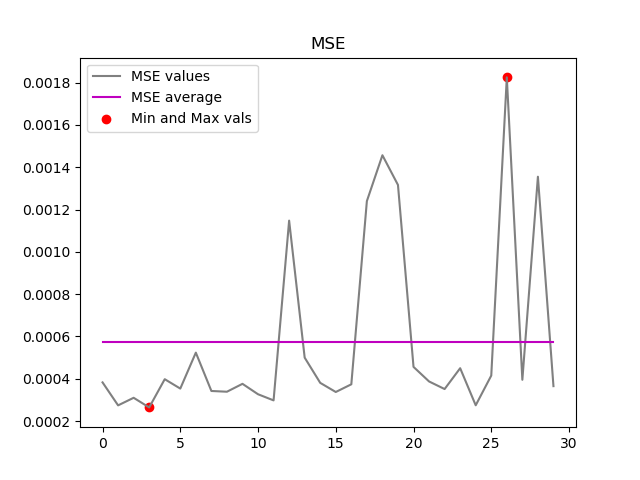

In [42]:
plot_mse(mse_list_100_70)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 60us/step
MSE: 0.011767423897981643


<IPython.core.display.Javascript object>


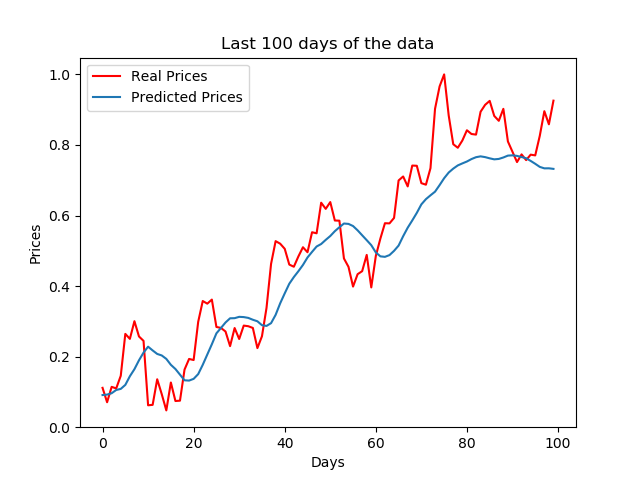

In [43]:
model1_100 = plot_predictions_and_real_prices_for_one_sample(model_100_70, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 39us/step
MSE: 0.0022995263217017053


<IPython.core.display.Javascript object>


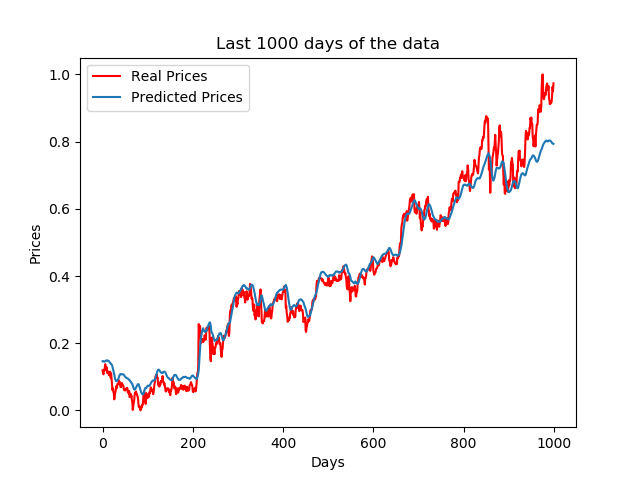

In [44]:
model1_1000 = plot_predictions_and_real_prices_for_one_sample(model_100_70, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 35us/step
MSE: 0.0016587698665680363


<IPython.core.display.Javascript object>


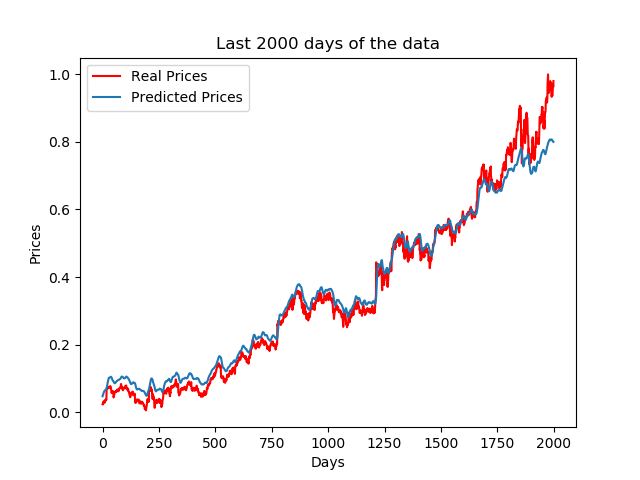

In [45]:
model1_2000 = plot_predictions_and_real_prices_for_one_sample(model_100_70, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# MODEL 2

## Training model 2:

**(100 input samples extracted, 50% training and 50% testing)**

In [46]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_100_50[epoch].shape)
    print(y_train_all_100_50[epoch].shape)
    
    # fit the model to the current data
    model_100_50.fit(X_train_all_100_50[epoch],
                     y_train_all_100_50[epoch],
                     validation_data=(X_val_all_100_50[epoch], y_val_all_100_50[epoch]),
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(1090, 54, 1)
(1090, 1)
Train on 1090 samples, validate on 546 samples
Epoch 1/20
1090/1090 [==============================] - 1s 805us/step - loss: 0.0575 - val_loss: 0.0557
Epoch 2/20
1090/1090 [==============================] - 0s 62us/step - loss: 0.0536 - val_loss: 0.0519
Epoch 3/20
1090/1090 [==============================] - 0s 69us/step - loss: 0.0499 - val_loss: 0.0482
Epoch 4/20
1090/1090 [==============================] - 0s 64us/step - loss: 0.0463 - val_loss: 0.0446
Epoch 5/20
1090/1090 [==============================] - 0s 66us/step - loss: 0.0429 - val_loss: 0.0412
Epoch 6/20
1090/1090 [==============================] - 0s 63us/step - loss: 0.0397 - val_loss: 0.0379
Epoch 7/20
1090/1090 [==============================] - 0s 60us/step - loss: 0.0366 - val_loss: 0.0349
Epoch 8/20
1090/1090 [==============================] - 0s 59us/step - loss: 0.0337 - val_loss: 0.0320
Epoch 9/20
1090/1090 [==============================] - 0s 61us/step - loss: 0.0310 - val_loss: 

Epoch 17/20
1083/1083 [==============================] - 0s 74us/step - loss: 0.0020 - val_loss: 0.0025
Epoch 18/20
1083/1083 [==============================] - 0s 78us/step - loss: 0.0020 - val_loss: 0.0025
Epoch 19/20
1083/1083 [==============================] - 0s 73us/step - loss: 0.0019 - val_loss: 0.0024
Epoch 20/20
1083/1083 [==============================] - 0s 76us/step - loss: 0.0019 - val_loss: 0.0024
epoch=4
(1088, 59, 1)
(1088, 1)
Train on 1088 samples, validate on 544 samples
Epoch 1/20
1088/1088 [==============================] - 0s 68us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 2/20
1088/1088 [==============================] - 0s 66us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3/20
1088/1088 [==============================] - 0s 64us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/20
1088/1088 [==============================] - 0s 68us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 5/20
1088/1088 [==============================] - 0s 63us/step - loss: 0.0017 - val_los

1086/1086 [==============================] - 0s 67us/step - loss: 7.0888e-04 - val_loss: 6.7420e-04
Epoch 2/20
1086/1086 [==============================] - 0s 64us/step - loss: 7.0555e-04 - val_loss: 6.7029e-04
Epoch 3/20
1086/1086 [==============================] - 0s 65us/step - loss: 7.0220e-04 - val_loss: 6.6596e-04
Epoch 4/20
1086/1086 [==============================] - 0s 62us/step - loss: 6.9913e-04 - val_loss: 6.6183e-04
Epoch 5/20
1086/1086 [==============================] - 0s 67us/step - loss: 6.9641e-04 - val_loss: 6.5841e-04
Epoch 6/20
1086/1086 [==============================] - 0s 70us/step - loss: 6.9432e-04 - val_loss: 6.5552e-04
Epoch 7/20
1086/1086 [==============================] - 0s 73us/step - loss: 6.9228e-04 - val_loss: 6.5281e-04
Epoch 8/20
1086/1086 [==============================] - 0s 62us/step - loss: 6.9005e-04 - val_loss: 6.5006e-04
Epoch 9/20
1086/1086 [==============================] - 0s 70us/step - loss: 6.8746e-04 - val_loss: 6.4725e-04
Epoch 10/20


Epoch 3/20
1111/1111 [==============================] - 0s 21us/step - loss: 7.6087e-04 - val_loss: 7.1587e-04
Epoch 4/20
1111/1111 [==============================] - 0s 25us/step - loss: 6.6125e-04 - val_loss: 6.4645e-04
Epoch 5/20
1111/1111 [==============================] - 0s 23us/step - loss: 5.9213e-04 - val_loss: 6.1356e-04
Epoch 6/20
1111/1111 [==============================] - 0s 24us/step - loss: 5.6024e-04 - val_loss: 6.1049e-04
Epoch 7/20
1111/1111 [==============================] - 0s 17us/step - loss: 5.5725e-04 - val_loss: 6.2393e-04
Epoch 8/20
1111/1111 [==============================] - 0s 22us/step - loss: 5.6821e-04 - val_loss: 6.3917e-04
Epoch 9/20
1111/1111 [==============================] - 0s 20us/step - loss: 5.8161e-04 - val_loss: 6.4818e-04
Epoch 10/20
1111/1111 [==============================] - 0s 26us/step - loss: 5.8938e-04 - val_loss: 6.4841e-04
Epoch 11/20
1111/1111 [==============================] - 0s 22us/step - loss: 5.8905e-04 - val_loss: 6.4029e-04

1083/1083 [==============================] - 0s 79us/step - loss: 3.4411e-04 - val_loss: 2.7527e-04
Epoch 5/20
1083/1083 [==============================] - 0s 85us/step - loss: 3.4283e-04 - val_loss: 2.7441e-04
Epoch 6/20
1083/1083 [==============================] - 0s 84us/step - loss: 3.4164e-04 - val_loss: 2.7354e-04
Epoch 7/20
1083/1083 [==============================] - 0s 86us/step - loss: 3.4078e-04 - val_loss: 2.7279e-04
Epoch 8/20
1083/1083 [==============================] - 0s 76us/step - loss: 3.3994e-04 - val_loss: 2.7216e-04
Epoch 9/20
1083/1083 [==============================] - 0s 81us/step - loss: 3.3921e-04 - val_loss: 2.7158e-04
Epoch 10/20
1083/1083 [==============================] - 0s 76us/step - loss: 3.3853e-04 - val_loss: 2.7092e-04
Epoch 11/20
1083/1083 [==============================] - 0s 74us/step - loss: 3.3779e-04 - val_loss: 2.7008e-04
Epoch 12/20
1083/1083 [==============================] - 0s 76us/step - loss: 3.3692e-04 - val_loss: 2.6906e-04
Epoch 13/

## Testing model 2:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_100_50, X_test_all_100_50, y_test_all_100_50)

In [48]:
mse_list_100_50 = mse_list(model_100_50, X_test_all_100_50, y_test_all_100_50, lengths)

Max mse: 0.0011127383746340764 (related window: 9)
Min mse: 0.0002081167124237658 (related window: 75)
Average mse: 0.0003738706561807503


<IPython.core.display.Javascript object>


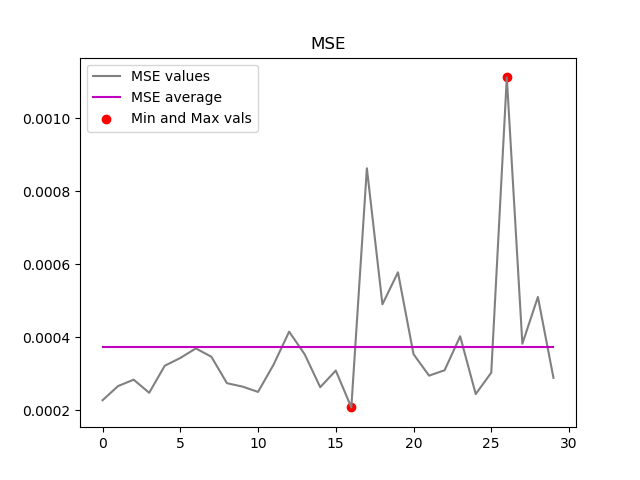

In [49]:
plot_mse(mse_list_100_50)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 90us/step
MSE: 0.009210257679224015


<IPython.core.display.Javascript object>


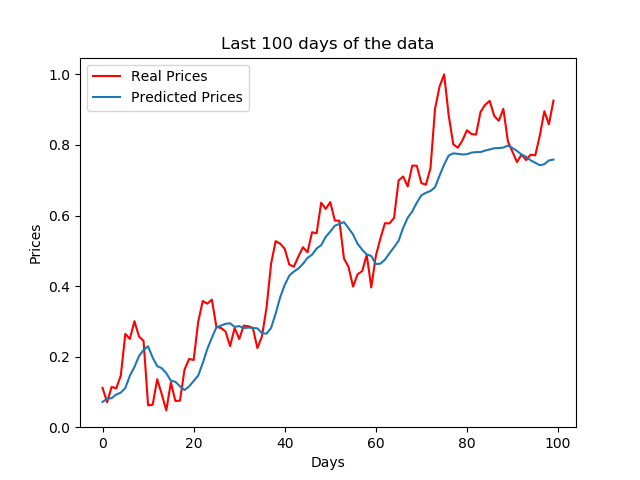

In [50]:
model2_100 = plot_predictions_and_real_prices_for_one_sample(model_100_50, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 35us/step
MSE: 0.0013763015009462833


<IPython.core.display.Javascript object>


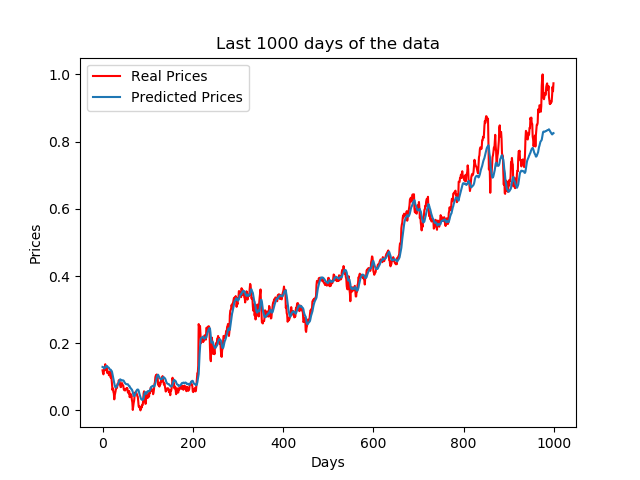

In [51]:
model2_1000 = plot_predictions_and_real_prices_for_one_sample(model_100_50, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 36us/step
MSE: 0.0008539462994085625


<IPython.core.display.Javascript object>


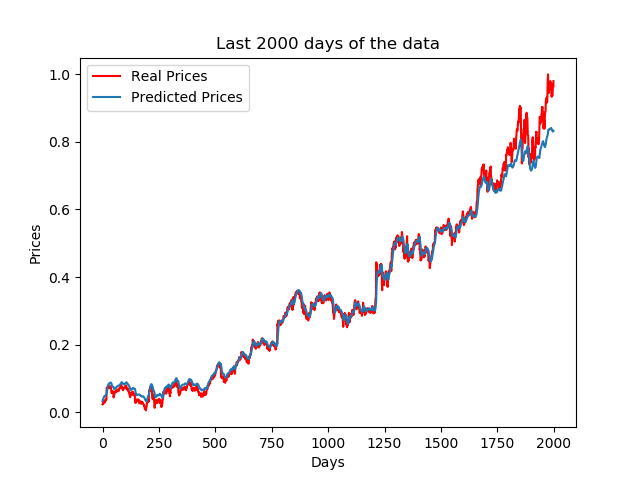

In [52]:
model2_2000 = plot_predictions_and_real_prices_for_one_sample(model_100_50, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# Model 3

## Training model 3:

**(1000 input samples extracted, 70% training and 30% testing)**

In [53]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_1000_70[epoch].shape)
    print(y_train_all_1000_70[epoch].shape)
    
    # fit the model to the current data
    model_1000_70.fit(X_train_all_1000_70[epoch],
                      y_train_all_1000_70[epoch],
                      validation_data=(X_val_all_1000_70[epoch], y_val_all_1000_70[epoch]),
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE)
    
    
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(896, 54, 1)
(896, 1)
Train on 896 samples, validate on 193 samples
Epoch 1/20
896/896 [==============================] - 1s 1ms/step - loss: 0.4237 - val_loss: 0.4575
Epoch 2/20
896/896 [==============================] - 0s 50us/step - loss: 0.4194 - val_loss: 0.4530
Epoch 3/20
896/896 [==============================] - 0s 38us/step - loss: 0.4151 - val_loss: 0.4485
Epoch 4/20
896/896 [==============================] - 0s 40us/step - loss: 0.4109 - val_loss: 0.4440
Epoch 5/20
896/896 [==============================] - 0s 38us/step - loss: 0.4067 - val_loss: 0.4395
Epoch 6/20
896/896 [==============================] - 0s 33us/step - loss: 0.4025 - val_loss: 0.4351
Epoch 7/20
896/896 [==============================] - 0s 35us/step - loss: 0.3983 - val_loss: 0.4306
Epoch 8/20
896/896 [==============================] - 0s 41us/step - loss: 0.3941 - val_loss: 0.4262
Epoch 9/20
896/896 [==============================] - 0s 35us/step - loss: 0.3900 - val_loss: 0.4218
Epoch 10/20
896/

Epoch 19/20
886/886 [==============================] - 0s 46us/step - loss: 0.1621 - val_loss: 0.1595
Epoch 20/20
886/886 [==============================] - 0s 46us/step - loss: 0.1595 - val_loss: 0.1569
epoch=4
(893, 59, 1)
(893, 1)
Train on 893 samples, validate on 192 samples
Epoch 1/20
893/893 [==============================] - 0s 40us/step - loss: 0.1580 - val_loss: 0.1733
Epoch 2/20
893/893 [==============================] - 0s 44us/step - loss: 0.1554 - val_loss: 0.1705
Epoch 3/20
893/893 [==============================] - 0s 41us/step - loss: 0.1528 - val_loss: 0.1677
Epoch 4/20
893/893 [==============================] - 0s 47us/step - loss: 0.1502 - val_loss: 0.1649
Epoch 5/20
893/893 [==============================] - 0s 45us/step - loss: 0.1477 - val_loss: 0.1621
Epoch 6/20
893/893 [==============================] - 0s 44us/step - loss: 0.1452 - val_loss: 0.1594
Epoch 7/20
893/893 [==============================] - 0s 44us/step - loss: 0.1427 - val_loss: 0.1566
Epoch 8/20
89

Epoch 17/20
868/868 [==============================] - 0s 72us/step - loss: 0.0480 - val_loss: 0.0494
Epoch 18/20
868/868 [==============================] - 0s 82us/step - loss: 0.0477 - val_loss: 0.0490
Epoch 19/20
868/868 [==============================] - 0s 65us/step - loss: 0.0473 - val_loss: 0.0487
Epoch 20/20
868/868 [==============================] - 0s 70us/step - loss: 0.0470 - val_loss: 0.0484
epoch=8
(870, 92, 1)
(870, 1)
Train on 870 samples, validate on 187 samples
Epoch 1/20
870/870 [==============================] - 0s 68us/step - loss: 0.0477 - val_loss: 0.0556
Epoch 2/20
870/870 [==============================] - 0s 68us/step - loss: 0.0474 - val_loss: 0.0552
Epoch 3/20
870/870 [==============================] - 0s 66us/step - loss: 0.0471 - val_loss: 0.0548
Epoch 4/20
870/870 [==============================] - 0s 70us/step - loss: 0.0468 - val_loss: 0.0545
Epoch 5/20
870/870 [==============================] - 0s 76us/step - loss: 0.0465 - val_loss: 0.0541
Epoch 6/20


Epoch 15/20
890/890 [==============================] - 0s 41us/step - loss: 0.0297 - val_loss: 0.0290
Epoch 16/20
890/890 [==============================] - 0s 38us/step - loss: 0.0294 - val_loss: 0.0288
Epoch 17/20
890/890 [==============================] - 0s 40us/step - loss: 0.0292 - val_loss: 0.0285
Epoch 18/20
890/890 [==============================] - 0s 41us/step - loss: 0.0289 - val_loss: 0.0283
Epoch 19/20
890/890 [==============================] - 0s 46us/step - loss: 0.0287 - val_loss: 0.0281
Epoch 20/20
890/890 [==============================] - 0s 45us/step - loss: 0.0285 - val_loss: 0.0278
epoch=12
(920, 20, 1)
(920, 1)
Train on 920 samples, validate on 198 samples
Epoch 1/20
920/920 [==============================] - 0s 18us/step - loss: 0.0315 - val_loss: 0.0274
Epoch 2/20
920/920 [==============================] - 0s 15us/step - loss: 0.0313 - val_loss: 0.0272
Epoch 3/20
920/920 [==============================] - 0s 15us/step - loss: 0.0311 - val_loss: 0.0270
Epoch 4/

Epoch 13/20
865/865 [==============================] - 0s 77us/step - loss: 0.0138 - val_loss: 0.0121
Epoch 14/20
865/865 [==============================] - 0s 73us/step - loss: 0.0136 - val_loss: 0.0119
Epoch 15/20
865/865 [==============================] - 0s 86us/step - loss: 0.0134 - val_loss: 0.0118
Epoch 16/20
865/865 [==============================] - 0s 76us/step - loss: 0.0132 - val_loss: 0.0116
Epoch 17/20
865/865 [==============================] - 0s 86us/step - loss: 0.0131 - val_loss: 0.0115
Epoch 18/20
865/865 [==============================] - 0s 81us/step - loss: 0.0129 - val_loss: 0.0113
Epoch 19/20
865/865 [==============================] - 0s 92us/step - loss: 0.0127 - val_loss: 0.0112
Epoch 20/20
865/865 [==============================] - 0s 74us/step - loss: 0.0126 - val_loss: 0.0110
epoch=16
(882, 75, 1)
(882, 1)
Train on 882 samples, validate on 189 samples
Epoch 1/20
882/882 [==============================] - 0s 59us/step - loss: 0.0119 - val_loss: 0.0114
Epoch 

Epoch 11/20
922/922 [==============================] - 0s 14us/step - loss: 0.0114 - val_loss: 0.0112
Epoch 12/20
922/922 [==============================] - 0s 18us/step - loss: 0.0111 - val_loss: 0.0109
Epoch 13/20
922/922 [==============================] - 0s 13us/step - loss: 0.0108 - val_loss: 0.0107
Epoch 14/20
922/922 [==============================] - 0s 13us/step - loss: 0.0105 - val_loss: 0.0104
Epoch 15/20
922/922 [==============================] - 0s 14us/step - loss: 0.0102 - val_loss: 0.0102
Epoch 16/20
922/922 [==============================] - 0s 14us/step - loss: 0.0099 - val_loss: 0.0100
Epoch 17/20
922/922 [==============================] - 0s 15us/step - loss: 0.0097 - val_loss: 0.0098
Epoch 18/20
922/922 [==============================] - 0s 13us/step - loss: 0.0095 - val_loss: 0.0096
Epoch 19/20
922/922 [==============================] - 0s 15us/step - loss: 0.0093 - val_loss: 0.0094
Epoch 20/20
922/922 [==============================] - 0s 13us/step - loss: 0.0091

Epoch 9/20
884/884 [==============================] - 0s 52us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 10/20
884/884 [==============================] - 0s 59us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 11/20
884/884 [==============================] - 0s 51us/step - loss: 0.0036 - val_loss: 0.0038
Epoch 12/20
884/884 [==============================] - 0s 60us/step - loss: 0.0036 - val_loss: 0.0038
Epoch 13/20
884/884 [==============================] - 0s 86us/step - loss: 0.0036 - val_loss: 0.0038
Epoch 14/20
884/884 [==============================] - 0s 46us/step - loss: 0.0036 - val_loss: 0.0038
Epoch 15/20
884/884 [==============================] - 0s 47us/step - loss: 0.0036 - val_loss: 0.0038
Epoch 16/20
884/884 [==============================] - 0s 54us/step - loss: 0.0036 - val_loss: 0.0037
Epoch 17/20
884/884 [==============================] - 0s 55us/step - loss: 0.0036 - val_loss: 0.0037
Epoch 18/20
884/884 [==============================] - 0s 58us/step - loss: 0.0036 

Epoch 7/20
896/896 [==============================] - 0s 41us/step - loss: 0.0090 - val_loss: 0.0086
Epoch 8/20
896/896 [==============================] - 0s 37us/step - loss: 0.0084 - val_loss: 0.0080
Epoch 9/20
896/896 [==============================] - 0s 35us/step - loss: 0.0077 - val_loss: 0.0074
Epoch 10/20
896/896 [==============================] - 0s 37us/step - loss: 0.0071 - val_loss: 0.0068
Epoch 11/20
896/896 [==============================] - 0s 33us/step - loss: 0.0064 - val_loss: 0.0062
Epoch 12/20
896/896 [==============================] - 0s 42us/step - loss: 0.0057 - val_loss: 0.0056
Epoch 13/20
896/896 [==============================] - 0s 37us/step - loss: 0.0051 - val_loss: 0.0050
Epoch 14/20
896/896 [==============================] - 0s 46us/step - loss: 0.0045 - val_loss: 0.0046
Epoch 15/20
896/896 [==============================] - 0s 37us/step - loss: 0.0040 - val_loss: 0.0041
Epoch 16/20
896/896 [==============================] - 0s 39us/step - loss: 0.0036 - 

## Testing model 3:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_1000_70, X_test_all_1000_70, y_test_all_1000_70)

In [55]:
mse_list_1000_70 = mse_list(model_1000_70, X_test_all_1000_70, y_test_all_1000_70, lengths)

Max mse: 0.02218189708252049 (related window: 9)
Min mse: 0.001691838846571984 (related window: 92)
Average mse: 0.0036392784697385507


<IPython.core.display.Javascript object>


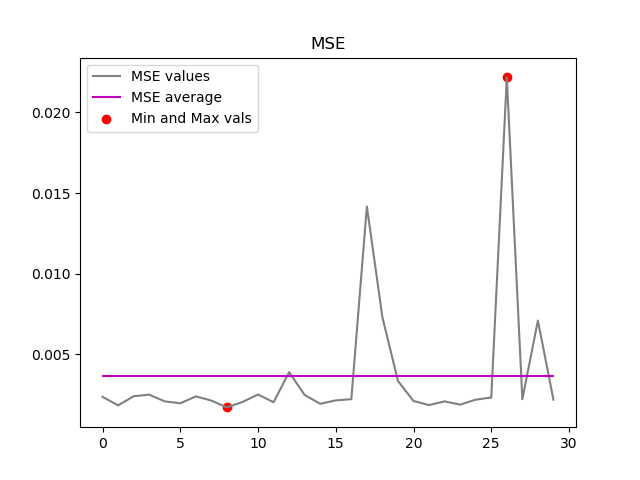

In [56]:
plot_mse(mse_list_1000_70)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 180us/step
MSE: 0.03298010468482971


<IPython.core.display.Javascript object>


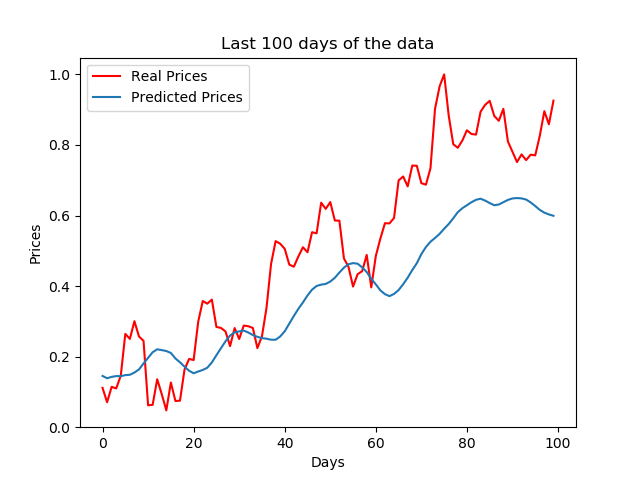

In [57]:
model3_100 = plot_predictions_and_real_prices_for_one_sample(model_1000_70, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 37us/step
MSE: 0.013376632548868657


<IPython.core.display.Javascript object>


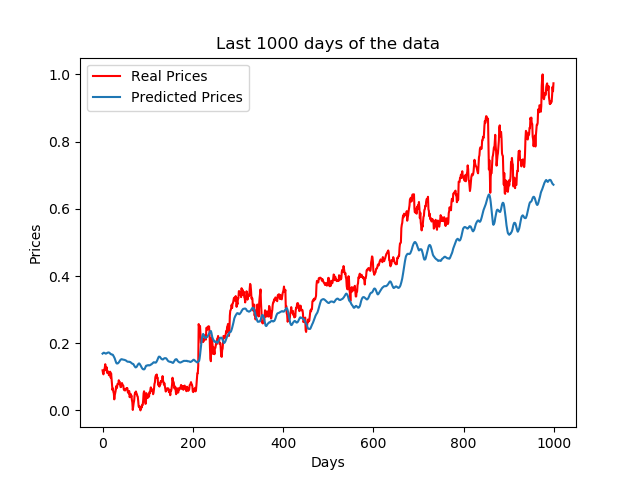

In [58]:
model3_1000 = plot_predictions_and_real_prices_for_one_sample(model_1000_70, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 31us/step
MSE: 0.011016352220904082


<IPython.core.display.Javascript object>


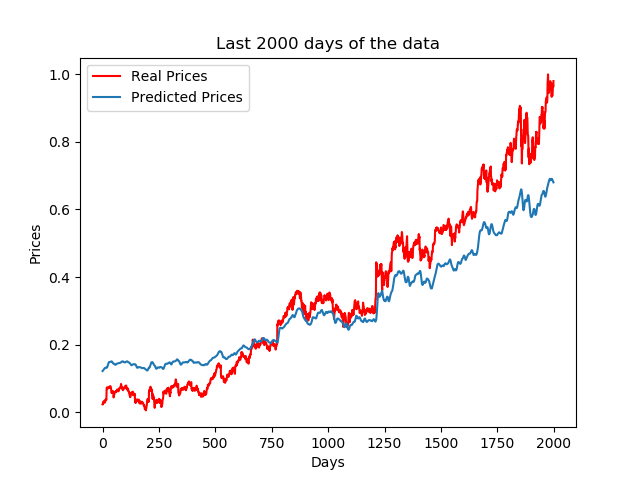

In [59]:
model3_2000 = plot_predictions_and_real_prices_for_one_sample(model_1000_70, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# MODEL 4

## Training model 4:

**(1000 input samples extracted, 50% training and 50% testing)**

In [60]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_1000_50[epoch].shape)
    print(y_train_all_1000_50[epoch].shape)
    
    # fit the model to the current data
    model_1000_50.fit(X_train_all_1000_50[epoch],
                      y_train_all_1000_50[epoch],
                      validation_data=(X_val_all_1000_50[epoch], y_val_all_1000_50[epoch]),
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(640, 54, 1)
(640, 1)
Train on 640 samples, validate on 321 samples
Epoch 1/20
640/640 [==============================] - 1s 2ms/step - loss: 0.2557 - val_loss: 0.2577
Epoch 2/20
640/640 [==============================] - 0s 50us/step - loss: 0.2534 - val_loss: 0.2547
Epoch 3/20
640/640 [==============================] - 0s 50us/step - loss: 0.2504 - val_loss: 0.2516
Epoch 4/20
640/640 [==============================] - 0s 70us/step - loss: 0.2474 - val_loss: 0.2486
Epoch 5/20
640/640 [==============================] - 0s 53us/step - loss: 0.2444 - val_loss: 0.2456
Epoch 6/20
640/640 [==============================] - 0s 45us/step - loss: 0.2414 - val_loss: 0.2426
Epoch 7/20
640/640 [==============================] - 0s 50us/step - loss: 0.2384 - val_loss: 0.2396
Epoch 8/20
640/640 [==============================] - 0s 47us/step - loss: 0.2355 - val_loss: 0.2367
Epoch 9/20
640/640 [==============================] - 0s 62us/step - loss: 0.2325 - val_loss: 0.2337
Epoch 10/20
640/

Epoch 19/20
633/633 [==============================] - 0s 74us/step - loss: 0.0727 - val_loss: 0.0751
Epoch 20/20
633/633 [==============================] - 0s 68us/step - loss: 0.0711 - val_loss: 0.0735
epoch=4
(638, 59, 1)
(638, 1)
Train on 638 samples, validate on 319 samples
Epoch 1/20
638/638 [==============================] - 0s 48us/step - loss: 0.0686 - val_loss: 0.0686
Epoch 2/20
638/638 [==============================] - 0s 53us/step - loss: 0.0670 - val_loss: 0.0671
Epoch 3/20
638/638 [==============================] - 0s 63us/step - loss: 0.0655 - val_loss: 0.0656
Epoch 4/20
638/638 [==============================] - 0s 64us/step - loss: 0.0640 - val_loss: 0.0643
Epoch 5/20
638/638 [==============================] - 0s 53us/step - loss: 0.0625 - val_loss: 0.0629
Epoch 6/20
638/638 [==============================] - 0s 56us/step - loss: 0.0611 - val_loss: 0.0616
Epoch 7/20
638/638 [==============================] - 0s 53us/step - loss: 0.0597 - val_loss: 0.0604
Epoch 8/20
63

Epoch 17/20
620/620 [==============================] - 0s 97us/step - loss: 0.0273 - val_loss: 0.0233
Epoch 18/20
620/620 [==============================] - 0s 82us/step - loss: 0.0269 - val_loss: 0.0230
Epoch 19/20
620/620 [==============================] - 0s 97us/step - loss: 0.0265 - val_loss: 0.0226
Epoch 20/20
620/620 [==============================] - 0s 77us/step - loss: 0.0262 - val_loss: 0.0223
epoch=8
(621, 92, 1)
(621, 1)
Train on 621 samples, validate on 311 samples
Epoch 1/20
621/621 [==============================] - 0s 84us/step - loss: 0.0221 - val_loss: 0.0240
Epoch 2/20
621/621 [==============================] - 0s 85us/step - loss: 0.0217 - val_loss: 0.0236
Epoch 3/20
621/621 [==============================] - 0s 92us/step - loss: 0.0214 - val_loss: 0.0233
Epoch 4/20
621/621 [==============================] - 0s 88us/step - loss: 0.0211 - val_loss: 0.0230
Epoch 5/20
621/621 [==============================] - 0s 90us/step - loss: 0.0208 - val_loss: 0.0226
Epoch 6/20


Epoch 15/20
636/636 [==============================] - 0s 52us/step - loss: 0.0078 - val_loss: 0.0078
Epoch 16/20
636/636 [==============================] - 0s 60us/step - loss: 0.0076 - val_loss: 0.0077
Epoch 17/20
636/636 [==============================] - 0s 66us/step - loss: 0.0075 - val_loss: 0.0076
Epoch 18/20
636/636 [==============================] - 0s 58us/step - loss: 0.0074 - val_loss: 0.0075
Epoch 19/20
636/636 [==============================] - 0s 67us/step - loss: 0.0073 - val_loss: 0.0074
Epoch 20/20
636/636 [==============================] - 0s 66us/step - loss: 0.0072 - val_loss: 0.0073
epoch=12
(657, 20, 1)
(657, 1)
Train on 657 samples, validate on 329 samples
Epoch 1/20
657/657 [==============================] - 0s 18us/step - loss: 0.0103 - val_loss: 0.0095
Epoch 2/20
657/657 [==============================] - 0s 21us/step - loss: 0.0101 - val_loss: 0.0094
Epoch 3/20
657/657 [==============================] - 0s 26us/step - loss: 0.0100 - val_loss: 0.0092
Epoch 4/

Epoch 13/20
618/618 [==============================] - 0s 92us/step - loss: 0.0041 - val_loss: 0.0044
Epoch 14/20
618/618 [==============================] - 0s 84us/step - loss: 0.0040 - val_loss: 0.0044
Epoch 15/20
618/618 [==============================] - 0s 86us/step - loss: 0.0040 - val_loss: 0.0044
Epoch 16/20
618/618 [==============================] - 0s 94us/step - loss: 0.0040 - val_loss: 0.0044
Epoch 17/20
618/618 [==============================] - 0s 86us/step - loss: 0.0040 - val_loss: 0.0043
Epoch 18/20
618/618 [==============================] - 0s 87us/step - loss: 0.0040 - val_loss: 0.0043
Epoch 19/20
618/618 [==============================] - 0s 98us/step - loss: 0.0039 - val_loss: 0.0043
Epoch 20/20
618/618 [==============================] - 0s 87us/step - loss: 0.0039 - val_loss: 0.0043
epoch=16
(630, 75, 1)
(630, 1)
Train on 630 samples, validate on 315 samples
Epoch 1/20
630/630 [==============================] - 0s 74us/step - loss: 0.0042 - val_loss: 0.0039
Epoch 

Epoch 11/20
659/659 [==============================] - 0s 20us/step - loss: 0.0042 - val_loss: 0.0046
Epoch 12/20
659/659 [==============================] - 0s 17us/step - loss: 0.0039 - val_loss: 0.0044
Epoch 13/20
659/659 [==============================] - 0s 18us/step - loss: 0.0037 - val_loss: 0.0042
Epoch 14/20
659/659 [==============================] - 0s 20us/step - loss: 0.0035 - val_loss: 0.0041
Epoch 15/20
659/659 [==============================] - 0s 18us/step - loss: 0.0034 - val_loss: 0.0040
Epoch 16/20
659/659 [==============================] - 0s 17us/step - loss: 0.0032 - val_loss: 0.0039
Epoch 17/20
659/659 [==============================] - 0s 18us/step - loss: 0.0031 - val_loss: 0.0038
Epoch 18/20
659/659 [==============================] - 0s 23us/step - loss: 0.0030 - val_loss: 0.0038
Epoch 19/20
659/659 [==============================] - 0s 23us/step - loss: 0.0030 - val_loss: 0.0038
Epoch 20/20
659/659 [==============================] - 0s 24us/step - loss: 0.0029

Epoch 9/20
631/631 [==============================] - 0s 73us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 10/20
631/631 [==============================] - 0s 60us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 11/20
631/631 [==============================] - 0s 65us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 12/20
631/631 [==============================] - 0s 79us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 13/20
631/631 [==============================] - 0s 71us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 14/20
631/631 [==============================] - 0s 70us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 15/20
631/631 [==============================] - 0s 70us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 16/20
631/631 [==============================] - 0s 68us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 17/20
631/631 [==============================] - 0s 62us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 18/20
631/631 [==============================] - 0s 68us/step - loss: 0.0022 

Epoch 7/20
640/640 [==============================] - 0s 48us/step - loss: 0.0086 - val_loss: 0.0071
Epoch 8/20
640/640 [==============================] - 0s 58us/step - loss: 0.0078 - val_loss: 0.0064
Epoch 9/20
640/640 [==============================] - 0s 65us/step - loss: 0.0070 - val_loss: 0.0056
Epoch 10/20
640/640 [==============================] - 0s 47us/step - loss: 0.0061 - val_loss: 0.0049
Epoch 11/20
640/640 [==============================] - 0s 48us/step - loss: 0.0054 - val_loss: 0.0042
Epoch 12/20
640/640 [==============================] - 0s 47us/step - loss: 0.0046 - val_loss: 0.0036
Epoch 13/20
640/640 [==============================] - 0s 67us/step - loss: 0.0040 - val_loss: 0.0031
Epoch 14/20
640/640 [==============================] - 0s 55us/step - loss: 0.0035 - val_loss: 0.0027
Epoch 15/20
640/640 [==============================] - 0s 45us/step - loss: 0.0030 - val_loss: 0.0024
Epoch 16/20
640/640 [==============================] - 0s 53us/step - loss: 0.0027 - 

## Testing model 4:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_1000_50, X_test_all_1000_50, y_test_all_1000_50)

In [62]:
mse_list_1000_50 = mse_list(model_1000_50, X_test_all_1000_50, y_test_all_1000_50, lengths)

Max mse: 0.010881905117581438 (related window: 9)
Min mse: 0.0014629515357183316 (related window: 39)
Average mse: 0.0024947034515227094


<IPython.core.display.Javascript object>


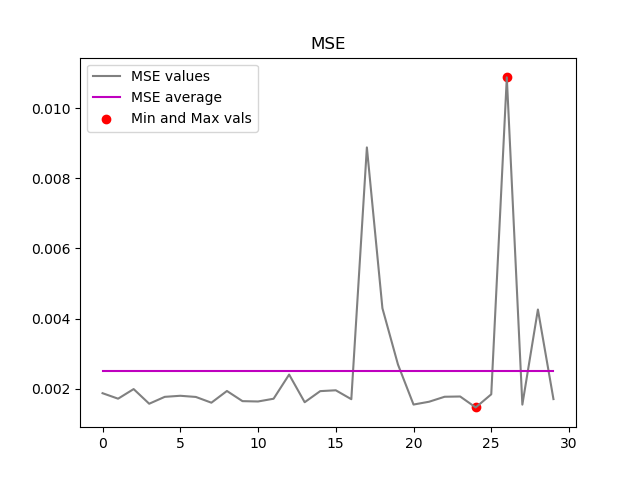

In [63]:
plot_mse(mse_list_1000_50)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 70us/step
MSE: 0.02377363383769989


<IPython.core.display.Javascript object>


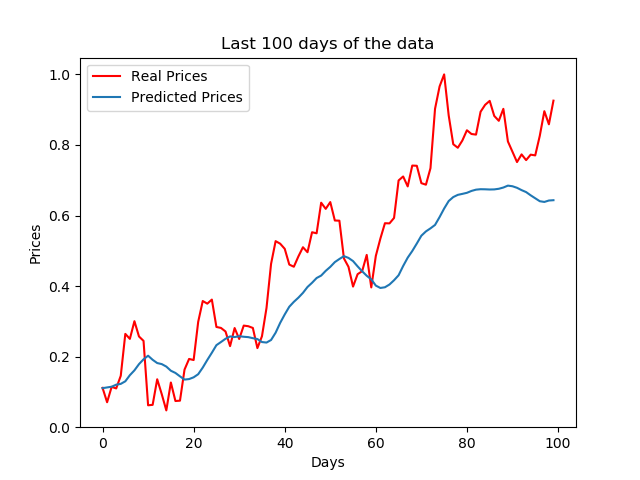

In [64]:
model4_100 = plot_predictions_and_real_prices_for_one_sample(model_1000_50, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 45us/step
MSE: 0.00894324316829443


<IPython.core.display.Javascript object>


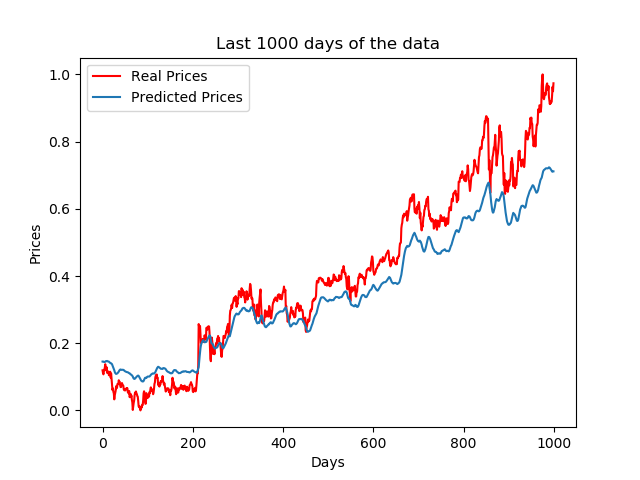

In [65]:
model4_1000 = plot_predictions_and_real_prices_for_one_sample(model_1000_50, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 38us/step
MSE: 0.007078442716388963


<IPython.core.display.Javascript object>


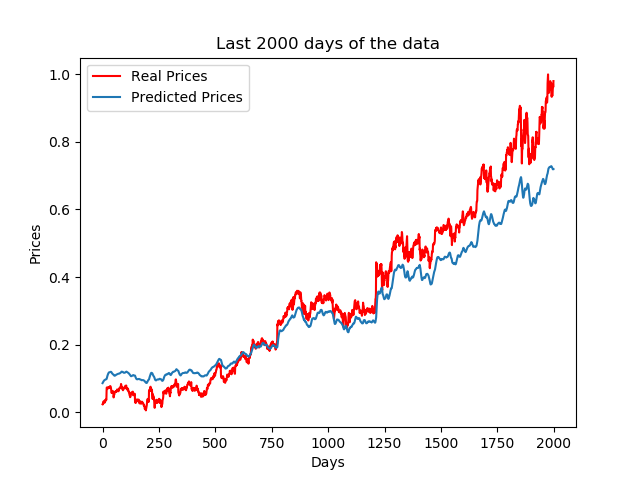

In [66]:
model4_2000 = plot_predictions_and_real_prices_for_one_sample(model_1000_50, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# MODEL 5

## Training model 5:

**(2000 input samples extracted, 70% training and 30% testing)**

In [67]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_2000_70[epoch].shape)
    print(y_train_all_2000_70[epoch].shape)
    
    # fit the model to the current data
    model_2000_70.fit(X_train_all_2000_70[epoch],
                      y_train_all_2000_70[epoch],
                      validation_data=(X_val_all_2000_70[epoch], y_val_all_2000_70[epoch]),
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(196, 54, 1)
(196, 1)
Train on 196 samples, validate on 43 samples
Epoch 1/20
196/196 [==============================] - 1s 5ms/step - loss: 0.3941 - val_loss: 0.3865
Epoch 2/20
196/196 [==============================] - 0s 117us/step - loss: 0.3911 - val_loss: 0.3824
Epoch 3/20
196/196 [==============================] - 0s 178us/step - loss: 0.3871 - val_loss: 0.3784
Epoch 4/20
196/196 [==============================] - 0s 117us/step - loss: 0.3830 - val_loss: 0.3744
Epoch 5/20
196/196 [==============================] - 0s 132us/step - loss: 0.3790 - val_loss: 0.3703
Epoch 6/20
196/196 [==============================] - 0s 132us/step - loss: 0.3750 - val_loss: 0.3663
Epoch 7/20
196/196 [==============================] - 0s 122us/step - loss: 0.3709 - val_loss: 0.3623
Epoch 8/20
196/196 [==============================] - 0s 127us/step - loss: 0.3669 - val_loss: 0.3583
Epoch 9/20
196/196 [==============================] - 0s 132us/step - loss: 0.3629 - val_loss: 0.3543
Epoch 10/

Epoch 19/20
186/186 [==============================] - 0s 166us/step - loss: 0.1132 - val_loss: 0.1402
Epoch 20/20
186/186 [==============================] - 0s 193us/step - loss: 0.1104 - val_loss: 0.1371
epoch=4
(193, 59, 1)
(193, 1)
Train on 193 samples, validate on 42 samples
Epoch 1/20
193/193 [==============================] - 0s 160us/step - loss: 0.1171 - val_loss: 0.0836
Epoch 2/20
193/193 [==============================] - 0s 186us/step - loss: 0.1144 - val_loss: 0.0813
Epoch 3/20
193/193 [==============================] - 0s 145us/step - loss: 0.1117 - val_loss: 0.0790
Epoch 4/20
193/193 [==============================] - 0s 140us/step - loss: 0.1090 - val_loss: 0.0768
Epoch 5/20
193/193 [==============================] - 0s 191us/step - loss: 0.1063 - val_loss: 0.0747
Epoch 6/20
193/193 [==============================] - 0s 155us/step - loss: 0.1037 - val_loss: 0.0725
Epoch 7/20
193/193 [==============================] - 0s 160us/step - loss: 0.1012 - val_loss: 0.0704
Epoch

Epoch 17/20
168/168 [==============================] - 0s 243us/step - loss: 0.0262 - val_loss: 0.0318
Epoch 18/20
168/168 [==============================] - 0s 261us/step - loss: 0.0260 - val_loss: 0.0315
Epoch 19/20
168/168 [==============================] - 0s 255us/step - loss: 0.0259 - val_loss: 0.0312
Epoch 20/20
168/168 [==============================] - 0s 261us/step - loss: 0.0258 - val_loss: 0.0309
epoch=8
(170, 92, 1)
(170, 1)
Train on 170 samples, validate on 37 samples
Epoch 1/20
170/170 [==============================] - 0s 270us/step - loss: 0.0267 - val_loss: 0.0248
Epoch 2/20
170/170 [==============================] - 0s 241us/step - loss: 0.0265 - val_loss: 0.0247
Epoch 3/20
170/170 [==============================] - 0s 246us/step - loss: 0.0264 - val_loss: 0.0245
Epoch 4/20
170/170 [==============================] - 0s 246us/step - loss: 0.0262 - val_loss: 0.0244
Epoch 5/20
170/170 [==============================] - 0s 252us/step - loss: 0.0261 - val_loss: 0.0242
Epo

Epoch 14/20
190/190 [==============================] - 0s 147us/step - loss: 0.0195 - val_loss: 0.0145
Epoch 15/20
190/190 [==============================] - 0s 152us/step - loss: 0.0194 - val_loss: 0.0145
Epoch 16/20
190/190 [==============================] - 0s 194us/step - loss: 0.0193 - val_loss: 0.0144
Epoch 17/20
190/190 [==============================] - 0s 163us/step - loss: 0.0193 - val_loss: 0.0144
Epoch 18/20
190/190 [==============================] - 0s 152us/step - loss: 0.0192 - val_loss: 0.0143
Epoch 19/20
190/190 [==============================] - 0s 178us/step - loss: 0.0191 - val_loss: 0.0143
Epoch 20/20
190/190 [==============================] - 0s 147us/step - loss: 0.0190 - val_loss: 0.0142
epoch=12
(220, 20, 1)
(220, 1)
Train on 220 samples, validate on 48 samples
Epoch 1/20
220/220 [==============================] - 0s 59us/step - loss: 0.0192 - val_loss: 0.0173
Epoch 2/20
220/220 [==============================] - 0s 54us/step - loss: 0.0191 - val_loss: 0.0172
E

Epoch 12/20
165/165 [==============================] - 0s 296us/step - loss: 0.0150 - val_loss: 0.0176
Epoch 13/20
165/165 [==============================] - 0s 254us/step - loss: 0.0149 - val_loss: 0.0175
Epoch 14/20
165/165 [==============================] - 0s 266us/step - loss: 0.0148 - val_loss: 0.0174
Epoch 15/20
165/165 [==============================] - 0s 242us/step - loss: 0.0147 - val_loss: 0.0174
Epoch 16/20
165/165 [==============================] - 0s 302us/step - loss: 0.0147 - val_loss: 0.0173
Epoch 17/20
165/165 [==============================] - 0s 254us/step - loss: 0.0146 - val_loss: 0.0172
Epoch 18/20
165/165 [==============================] - 0s 520us/step - loss: 0.0146 - val_loss: 0.0172
Epoch 19/20
165/165 [==============================] - 0s 266us/step - loss: 0.0145 - val_loss: 0.0171
Epoch 20/20
165/165 [==============================] - 0s 278us/step - loss: 0.0144 - val_loss: 0.0170
epoch=16
(182, 75, 1)
(182, 1)
Train on 182 samples, validate on 39 sampl

Epoch 10/20
222/222 [==============================] - 0s 49us/step - loss: 0.0119 - val_loss: 0.0123
Epoch 11/20
222/222 [==============================] - 0s 54us/step - loss: 0.0117 - val_loss: 0.0121
Epoch 12/20
222/222 [==============================] - 0s 45us/step - loss: 0.0114 - val_loss: 0.0118
Epoch 13/20
222/222 [==============================] - 0s 45us/step - loss: 0.0112 - val_loss: 0.0117
Epoch 14/20
222/222 [==============================] - 0s 49us/step - loss: 0.0110 - val_loss: 0.0115
Epoch 15/20
222/222 [==============================] - 0s 54us/step - loss: 0.0108 - val_loss: 0.0114
Epoch 16/20
222/222 [==============================] - 0s 45us/step - loss: 0.0107 - val_loss: 0.0112
Epoch 17/20
222/222 [==============================] - 0s 45us/step - loss: 0.0106 - val_loss: 0.0111
Epoch 18/20
222/222 [==============================] - 0s 54us/step - loss: 0.0105 - val_loss: 0.0110
Epoch 19/20
222/222 [==============================] - 0s 54us/step - loss: 0.0104

184/184 [==============================] - 0s 184us/step - loss: 0.0096 - val_loss: 0.0069
Epoch 8/20
184/184 [==============================] - 0s 168us/step - loss: 0.0095 - val_loss: 0.0069
Epoch 9/20
184/184 [==============================] - 0s 163us/step - loss: 0.0095 - val_loss: 0.0069
Epoch 10/20
184/184 [==============================] - 0s 233us/step - loss: 0.0095 - val_loss: 0.0069
Epoch 11/20
184/184 [==============================] - 0s 195us/step - loss: 0.0095 - val_loss: 0.0069
Epoch 12/20
184/184 [==============================] - 0s 163us/step - loss: 0.0094 - val_loss: 0.0069
Epoch 13/20
184/184 [==============================] - 0s 168us/step - loss: 0.0094 - val_loss: 0.0069
Epoch 14/20
184/184 [==============================] - 0s 195us/step - loss: 0.0094 - val_loss: 0.0069
Epoch 15/20
184/184 [==============================] - 0s 233us/step - loss: 0.0094 - val_loss: 0.0069
Epoch 16/20
184/184 [==============================] - 0s 173us/step - loss: 0.0094 - v

Epoch 5/20
196/196 [==============================] - 0s 137us/step - loss: 0.0165 - val_loss: 0.0131
Epoch 6/20
196/196 [==============================] - 0s 127us/step - loss: 0.0151 - val_loss: 0.0115
Epoch 7/20
196/196 [==============================] - 0s 132us/step - loss: 0.0136 - val_loss: 0.0099
Epoch 8/20
196/196 [==============================] - 0s 132us/step - loss: 0.0122 - val_loss: 0.0085
Epoch 9/20
196/196 [==============================] - 0s 127us/step - loss: 0.0109 - val_loss: 0.0074
Epoch 10/20
196/196 [==============================] - 0s 132us/step - loss: 0.0099 - val_loss: 0.0065
Epoch 11/20
196/196 [==============================] - 0s 137us/step - loss: 0.0091 - val_loss: 0.0060
Epoch 12/20
196/196 [==============================] - 0s 137us/step - loss: 0.0085 - val_loss: 0.0058
Epoch 13/20
196/196 [==============================] - 0s 153us/step - loss: 0.0082 - val_loss: 0.0058
Epoch 14/20
196/196 [==============================] - 0s 148us/step - loss: 0

## Testing model 5:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_2000_70, X_test_all_2000_70, y_test_all_2000_70)

In [69]:
mse_list_2000_70 = mse_list(model_2000_70, X_test_all_2000_70, y_test_all_2000_70, lengths)

Max mse: 0.014236317472342325 (related window: 9)
Min mse: 0.005943188547260231 (related window: 94)
Average mse: 0.008299954939102103


<IPython.core.display.Javascript object>


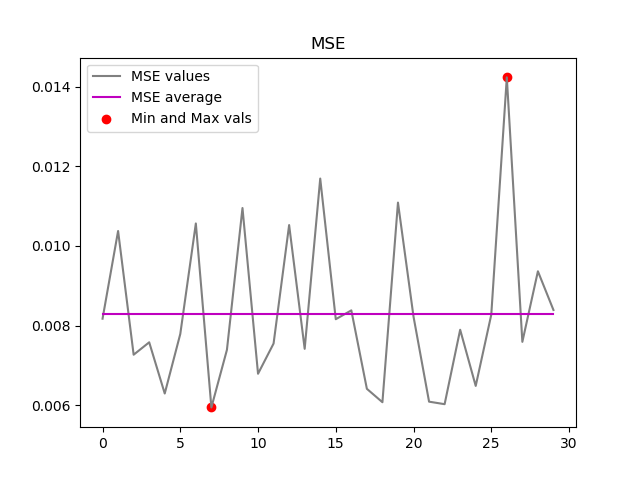

In [70]:
plot_mse(mse_list_2000_70)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 80us/step
MSE: 0.017406435906887053


<IPython.core.display.Javascript object>


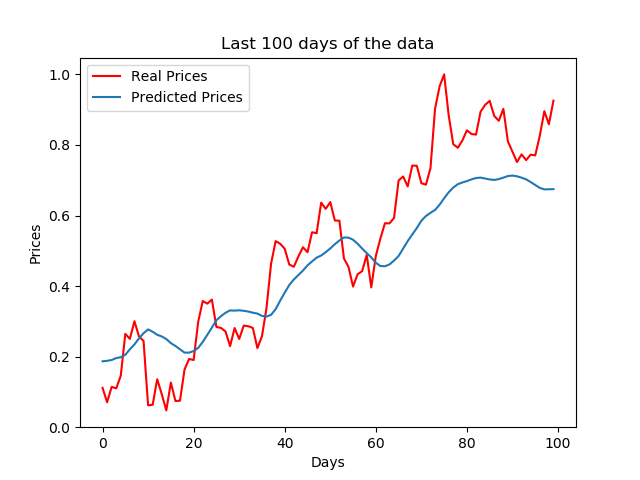

In [71]:
model5_100 = plot_predictions_and_real_prices_for_one_sample(model_2000_70, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 45us/step
MSE: 0.008199042910709976


<IPython.core.display.Javascript object>


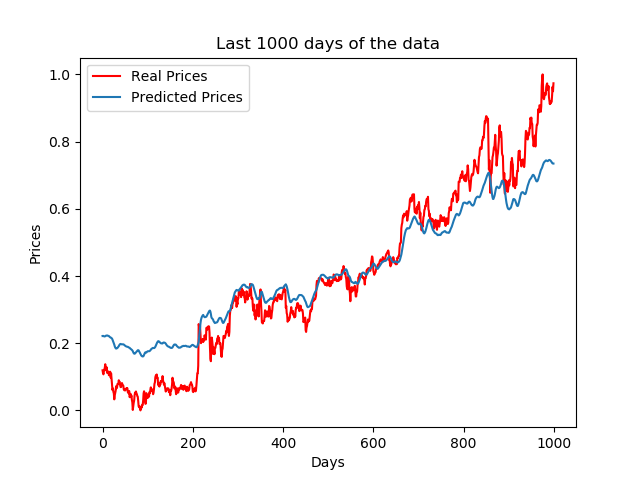

In [72]:
model5_1000 = plot_predictions_and_real_prices_for_one_sample(model_2000_70, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 42us/step
MSE: 0.008469029795844107


<IPython.core.display.Javascript object>


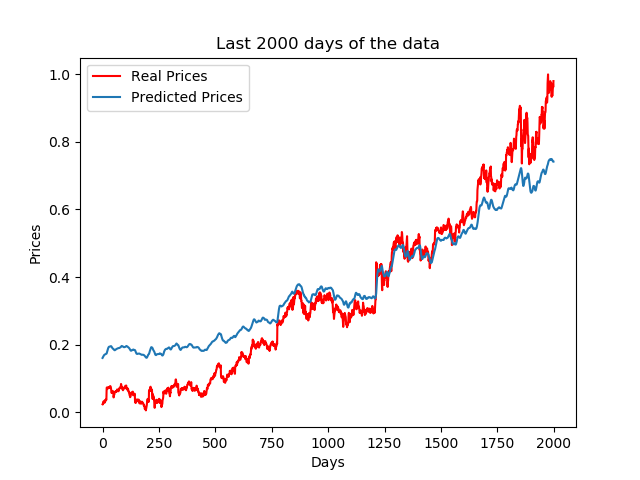

In [73]:
model5_2000 = plot_predictions_and_real_prices_for_one_sample(model_2000_70, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# MODEL 6

## Training model 6:

**(2000 input samples extracted, 50% training and 50% testing)**

In [74]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_2000_50[epoch].shape)
    print(y_train_all_2000_50[epoch].shape)
    
    # fit the model to the current data
    model_2000_50.fit(X_train_all_2000_50[epoch],
                      y_train_all_2000_50[epoch],
                      validation_data=(X_val_all_2000_50[epoch], y_val_all_2000_50[epoch]),
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(140, 54, 1)
(140, 1)
Train on 140 samples, validate on 71 samples
Epoch 1/20
140/140 [==============================] - 1s 8ms/step - loss: 0.4489 - val_loss: 0.4538
Epoch 2/20
140/140 [==============================] - 0s 185us/step - loss: 0.4421 - val_loss: 0.4470
Epoch 3/20
140/140 [==============================] - 0s 192us/step - loss: 0.4355 - val_loss: 0.4403
Epoch 4/20
140/140 [==============================] - 0s 221us/step - loss: 0.4288 - val_loss: 0.4336
Epoch 5/20
140/140 [==============================] - 0s 185us/step - loss: 0.4223 - val_loss: 0.4270
Epoch 6/20
140/140 [==============================] - 0s 171us/step - loss: 0.4158 - val_loss: 0.4205
Epoch 7/20
140/140 [==============================] - 0s 171us/step - loss: 0.4094 - val_loss: 0.4141
Epoch 8/20
140/140 [==============================] - 0s 199us/step - loss: 0.4031 - val_loss: 0.4078
Epoch 9/20
140/140 [==============================] - 0s 228us/step - loss: 0.3969 - val_loss: 0.4015
Epoch 10/

133/133 [==============================] - 0s 225us/step - loss: 0.1140 - val_loss: 0.0913
Epoch 19/20
133/133 [==============================] - 0s 240us/step - loss: 0.1109 - val_loss: 0.0887
Epoch 20/20
133/133 [==============================] - 0s 217us/step - loss: 0.1079 - val_loss: 0.0860
epoch=4
(138, 59, 1)
(138, 1)
Train on 138 samples, validate on 69 samples
Epoch 1/20
138/138 [==============================] - 0s 195us/step - loss: 0.0908 - val_loss: 0.0985
Epoch 2/20
138/138 [==============================] - 0s 217us/step - loss: 0.0881 - val_loss: 0.0956
Epoch 3/20
138/138 [==============================] - 0s 217us/step - loss: 0.0854 - val_loss: 0.0928
Epoch 4/20
138/138 [==============================] - 0s 188us/step - loss: 0.0828 - val_loss: 0.0901
Epoch 5/20
138/138 [==============================] - 0s 224us/step - loss: 0.0803 - val_loss: 0.0874
Epoch 6/20
138/138 [==============================] - 0s 231us/step - loss: 0.0778 - val_loss: 0.0848
Epoch 7/20
138/1

Epoch 16/20
120/120 [==============================] - 0s 332us/step - loss: 0.0287 - val_loss: 0.0258
Epoch 17/20
120/120 [==============================] - 0s 332us/step - loss: 0.0286 - val_loss: 0.0257
Epoch 18/20
120/120 [==============================] - 0s 416us/step - loss: 0.0285 - val_loss: 0.0257
Epoch 19/20
120/120 [==============================] - 0s 382us/step - loss: 0.0284 - val_loss: 0.0256
Epoch 20/20
120/120 [==============================] - 0s 316us/step - loss: 0.0283 - val_loss: 0.0255
epoch=8
(121, 92, 1)
(121, 1)
Train on 121 samples, validate on 61 samples
Epoch 1/20
121/121 [==============================] - 0s 313us/step - loss: 0.0218 - val_loss: 0.0294
Epoch 2/20
121/121 [==============================] - 0s 346us/step - loss: 0.0217 - val_loss: 0.0293
Epoch 3/20
121/121 [==============================] - 0s 330us/step - loss: 0.0216 - val_loss: 0.0292
Epoch 4/20
121/121 [==============================] - 0s 321us/step - loss: 0.0216 - val_loss: 0.0290
Ep

Epoch 13/20
136/136 [==============================] - 0s 227us/step - loss: 0.0204 - val_loss: 0.0152
Epoch 14/20
136/136 [==============================] - 0s 205us/step - loss: 0.0202 - val_loss: 0.0153
Epoch 15/20
136/136 [==============================] - 0s 213us/step - loss: 0.0201 - val_loss: 0.0153
Epoch 16/20
136/136 [==============================] - 0s 213us/step - loss: 0.0199 - val_loss: 0.0154
Epoch 17/20
136/136 [==============================] - 0s 242us/step - loss: 0.0198 - val_loss: 0.0155
Epoch 18/20
136/136 [==============================] - 0s 227us/step - loss: 0.0197 - val_loss: 0.0155
Epoch 19/20
136/136 [==============================] - 0s 213us/step - loss: 0.0195 - val_loss: 0.0156
Epoch 20/20
136/136 [==============================] - 0s 205us/step - loss: 0.0194 - val_loss: 0.0157
epoch=12
(157, 20, 1)
(157, 1)
Train on 157 samples, validate on 79 samples
Epoch 1/20
157/157 [==============================] - 0s 70us/step - loss: 0.0171 - val_loss: 0.0240

Epoch 11/20
118/118 [==============================] - 0s 380us/step - loss: 0.0145 - val_loss: 0.0166
Epoch 12/20
118/118 [==============================] - 0s 372us/step - loss: 0.0144 - val_loss: 0.0166
Epoch 13/20
118/118 [==============================] - 0s 380us/step - loss: 0.0144 - val_loss: 0.0165
Epoch 14/20
118/118 [==============================] - 0s 372us/step - loss: 0.0143 - val_loss: 0.0165
Epoch 15/20
118/118 [==============================] - 0s 372us/step - loss: 0.0143 - val_loss: 0.0164
Epoch 16/20
118/118 [==============================] - 0s 380us/step - loss: 0.0142 - val_loss: 0.0164
Epoch 17/20
118/118 [==============================] - 0s 380us/step - loss: 0.0142 - val_loss: 0.0163
Epoch 18/20
118/118 [==============================] - 0s 423us/step - loss: 0.0141 - val_loss: 0.0163
Epoch 19/20
118/118 [==============================] - 0s 363us/step - loss: 0.0141 - val_loss: 0.0162
Epoch 20/20
118/118 [==============================] - 0s 406us/step - lo

Epoch 9/20
159/159 [==============================] - 0s 82us/step - loss: 0.0173 - val_loss: 0.0152
Epoch 10/20
159/159 [==============================] - 0s 75us/step - loss: 0.0166 - val_loss: 0.0146
Epoch 11/20
159/159 [==============================] - 0s 63us/step - loss: 0.0160 - val_loss: 0.0141
Epoch 12/20
159/159 [==============================] - 0s 63us/step - loss: 0.0154 - val_loss: 0.0136
Epoch 13/20
159/159 [==============================] - 0s 56us/step - loss: 0.0149 - val_loss: 0.0132
Epoch 14/20
159/159 [==============================] - 0s 63us/step - loss: 0.0144 - val_loss: 0.0128
Epoch 15/20
159/159 [==============================] - 0s 63us/step - loss: 0.0140 - val_loss: 0.0125
Epoch 16/20
159/159 [==============================] - 0s 69us/step - loss: 0.0136 - val_loss: 0.0122
Epoch 17/20
159/159 [==============================] - 0s 69us/step - loss: 0.0133 - val_loss: 0.0120
Epoch 18/20
159/159 [==============================] - 0s 69us/step - loss: 0.0130 

131/131 [==============================] - 0s 236us/step - loss: 0.0094 - val_loss: 0.0099
Epoch 7/20
131/131 [==============================] - 0s 259us/step - loss: 0.0094 - val_loss: 0.0098
Epoch 8/20
131/131 [==============================] - 0s 251us/step - loss: 0.0094 - val_loss: 0.0098
Epoch 9/20
131/131 [==============================] - 0s 297us/step - loss: 0.0093 - val_loss: 0.0098
Epoch 10/20
131/131 [==============================] - 0s 236us/step - loss: 0.0093 - val_loss: 0.0098
Epoch 11/20
131/131 [==============================] - 0s 221us/step - loss: 0.0093 - val_loss: 0.0098
Epoch 12/20
131/131 [==============================] - 0s 228us/step - loss: 0.0093 - val_loss: 0.0098
Epoch 13/20
131/131 [==============================] - 0s 259us/step - loss: 0.0093 - val_loss: 0.0097
Epoch 14/20
131/131 [==============================] - 0s 320us/step - loss: 0.0092 - val_loss: 0.0097
Epoch 15/20
131/131 [==============================] - 0s 244us/step - loss: 0.0092 - va

Epoch 4/20
140/140 [==============================] - 0s 214us/step - loss: 0.0154 - val_loss: 0.0133
Epoch 5/20
140/140 [==============================] - 0s 171us/step - loss: 0.0151 - val_loss: 0.0129
Epoch 6/20
140/140 [==============================] - 0s 199us/step - loss: 0.0146 - val_loss: 0.0124
Epoch 7/20
140/140 [==============================] - 0s 199us/step - loss: 0.0141 - val_loss: 0.0119
Epoch 8/20
140/140 [==============================] - 0s 185us/step - loss: 0.0134 - val_loss: 0.0113
Epoch 9/20
140/140 [==============================] - 0s 192us/step - loss: 0.0128 - val_loss: 0.0107
Epoch 10/20
140/140 [==============================] - 0s 192us/step - loss: 0.0121 - val_loss: 0.0102
Epoch 11/20
140/140 [==============================] - 0s 178us/step - loss: 0.0115 - val_loss: 0.0097
Epoch 12/20
140/140 [==============================] - 0s 178us/step - loss: 0.0109 - val_loss: 0.0093
Epoch 13/20
140/140 [==============================] - 0s 171us/step - loss: 0.

## Testing model 6:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_2000_50, X_test_all_2000_50, y_test_all_2000_50)

In [76]:
mse_list_2000_50 = mse_list(model_2000_50, X_test_all_2000_50, y_test_all_2000_50, lengths)

Max mse: 0.01604225136983542 (related window: 9)
Min mse: 0.00578303325592595 (related window: 63)
Average mse: 0.007922773434988378


<IPython.core.display.Javascript object>


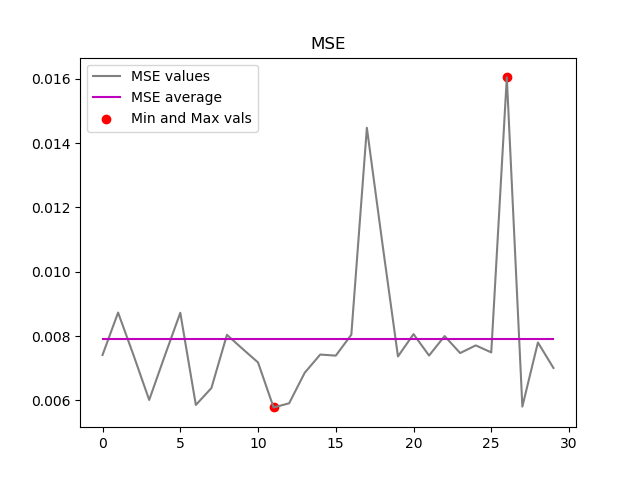

In [77]:
plot_mse(mse_list_2000_50)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 80us/step
MSE: 0.022020693123340606


<IPython.core.display.Javascript object>


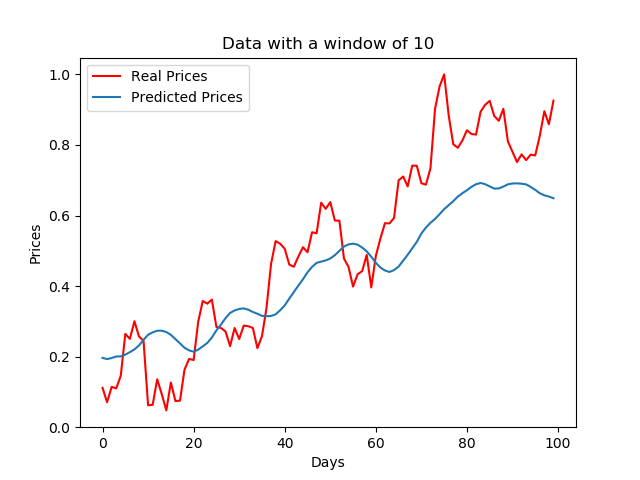

In [78]:
model6_100 = plot_predictions_and_real_prices_for_one_sample(model_2000_50, X_test_sample_100, y_test_sample_100)

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 40us/step
MSE: 0.010145525904372335


<IPython.core.display.Javascript object>


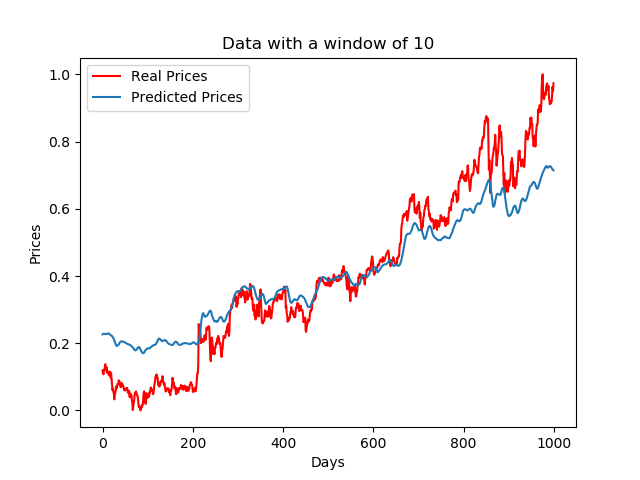

In [79]:
model6_1000 = plot_predictions_and_real_prices_for_one_sample(model_2000_50, X_test_sample_1000, y_test_sample_1000)

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 47us/step
MSE: 0.010218261740170419


<IPython.core.display.Javascript object>


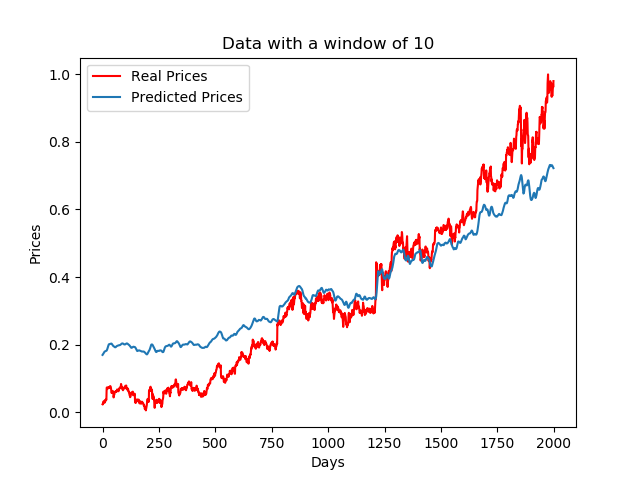

In [80]:
model6_2000 = plot_predictions_and_real_prices_for_one_sample(model_2000_50, X_test_sample_2000, y_test_sample_2000)

# Comparing Models

## Visually:

Prepare the lists that are needed as parameters for the functions that will be used.

In [81]:
all_test_mse_lists = [mse_list_100_70, # list of MSE values for the Model 1 on Testing data
                     mse_list_100_50, # list of MSE values for the Model 2 on Testing data
                     mse_list_1000_70, # list of MSE values for the Model 3 on Testing data
                     mse_list_1000_50, # list of MSE values for the Model 4 on Testing data
                     mse_list_2000_70, # list of MSE values for the Model 5 on Testing data
                     mse_list_2000_70 # list of MSE values for the Model 6 on Testing data
                    ]
# MSE for each model on the 100 saved unseen input sample
all_100_mse_list = [model1_100, model2_100, model3_100, model4_100, model5_100, model6_100]
# MSE for each model on the 1000 saved unseen input sample
all_1000_mse_list = [model1_1000, model2_1000, model3_1000, model4_1000, model5_1000, model6_1000]
# MSE for each model on the 2000 saved unseen input sample
all_2000_mse_list = [model1_2000, model2_2000, model3_2000, model4_2000, model5_2000, model6_2000]

In [82]:
x_ticks_labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']

## Plot MSE for models on testing data

Concretely, three barplots will be plotted showing the minimum, maximum and average MSE values, respectively, on the testing data.

<IPython.core.display.Javascript object>


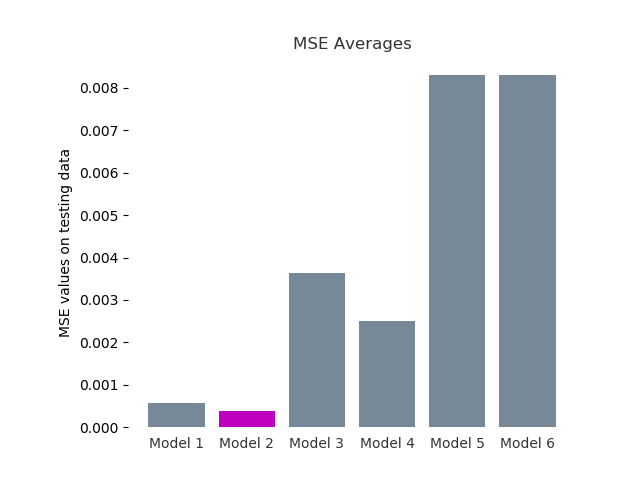

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


<IPython.core.display.Javascript object>


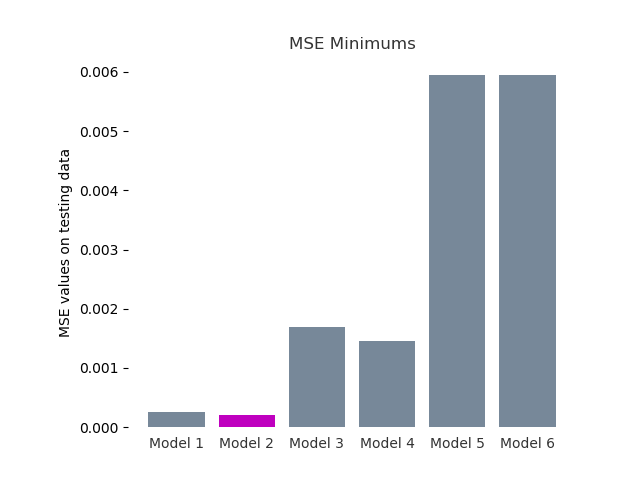

<IPython.core.display.Javascript object>


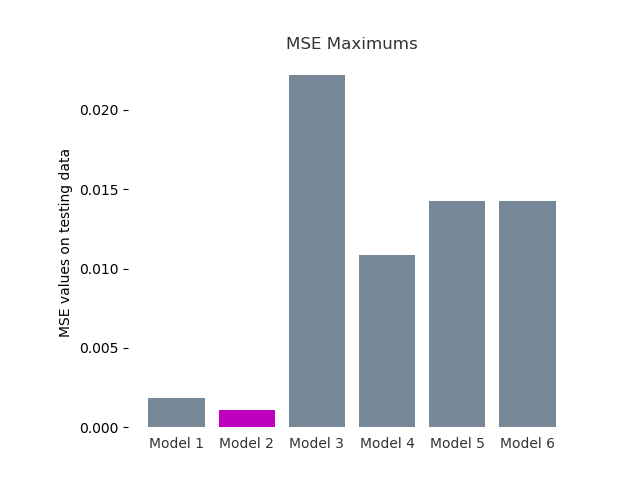

In [83]:
visualize_models_on_testing_data(all_test_mse_lists)

## Plot MSE for models on last 100 days

<IPython.core.display.Javascript object>


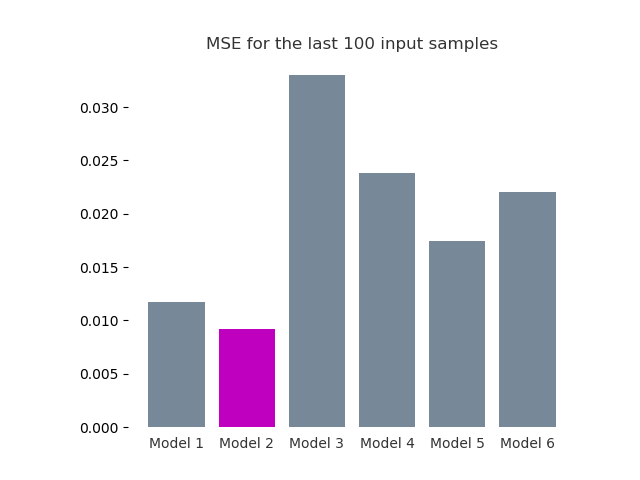

In [84]:
barplot(all_100_mse_list, x_ticks_labels, title='MSE for the last 100 input samples', 
        remove_ticks=True, remove_frame=True)

## Plot MSE for models on last 1000 days

<IPython.core.display.Javascript object>


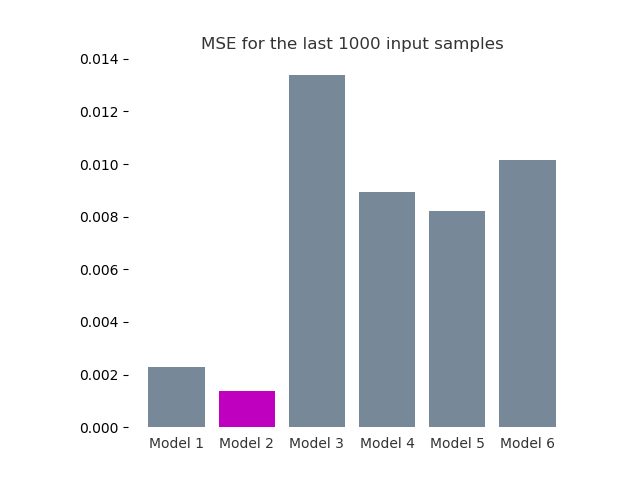

In [85]:
barplot(all_1000_mse_list, x_ticks_labels, title='MSE for the last 1000 input samples', 
        remove_ticks=True, remove_frame=True)

## Plot MSE for models on last 2000 days

<IPython.core.display.Javascript object>


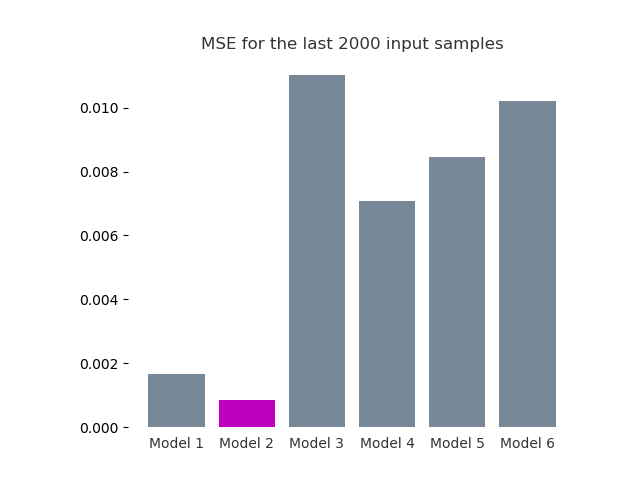

In [86]:
barplot(all_2000_mse_list, x_ticks_labels, title='MSE for the last 2000 input samples', 
        remove_ticks=True, remove_frame=True)

# Tabularly

Prepare the lists that are needed as parameters for the functions that will be used.

In [87]:
models = [model_100_70, model_100_50, model_1000_70, model_1000_50, model_2000_70, model_2000_50]
# Each sample for the last (100, 1000, and 2000) days:
X_test_lists = [X_test_sample_100, X_test_sample_1000, X_test_sample_2000]
y_test_lists = [y_test_sample_100, y_test_sample_1000, y_test_sample_2000]

In [88]:
models_names =  ['model_100_70','model_100_50','model_1000_70','model_1000_50','model_2000_70','model_2000_50']

In [89]:
mse_on_test_data = [ mse_list_100_70, mse_list_100_50, mse_list_1000_70, mse_list_1000_50, 
                    mse_list_2000_70, mse_list_2000_50]

## MSE on testing data

Evaluate each model's performance on each (X,y) pair of Numpy arrays (each generated with a different length of sequences) in the testing data.

In [90]:
mse_on_test_df = mse_on_testing_data_df(mse_on_test_data, models_names, lengths)
mse_on_test_df

,model_100_70,model_100_50,model_1000_70,model_1000_50,model_2000_70,model_2000_50
54,0.000383,0.000228,0.002350,0.001870,0.008173,0.007415
94,0.000274,0.000267,0.001820,0.001713,0.010376,0.008732
33,0.000310,0.000284,0.002387,0.001987,0.007268,0.007397
68,0.000264,0.000248,0.002487,0.001569,0.007580,0.006016
59,0.000398,0.000322,0.002068,0.001766,0.006293,0.007385
86,0.000353,0.000344,0.001952,0.001796,0.007790,0.008725
27,0.000523,0.000370,0.002380,0.001763,0.010566,0.005861
94,0.000342,0.000347,0.002118,0.001599,0.005943,0.006385
92,0.000339,0.000275,0.001692,0.001933,0.007391,0.008040
87,0.000376,0.000265,0.002032,0.001643,0.010954,0.007606


## MSE on the last samples

Evaluate each model's performance on each of the last 100, 1000 and 2000 days (totally unseen data).

In [91]:
mse_last_samples_df = mse_on_samples_df(models, X_test_lists, y_test_lists, 
                                        ['last_100_days','last_1000_days','last_2000_days'], models_names)
mse_last_samples_df

,model,last_100_days,last_1000_days,last_2000_days
0,model_100_70,0.011767,0.002300,0.001659
1,model_100_50,0.009210,0.001376,0.000854
2,model_1000_70,0.032980,0.013377,0.011016
3,model_1000_50,0.023774,0.008943,0.007078
4,model_2000_70,0.017406,0.008199,0.008469
5,model_2000_50,0.022021,0.010146,0.010218


# Saving the models

In [92]:
main_path = "E:\\Senior-Year  graduation project\\Latest results and models - 26-May-2019\\"

In [93]:
path_100_70 = "Google models - with validation\\model_100_70.h5"
path_100_50 = "Google models - with validation\\model_100_50.h5"

path_1000_70 = "Google models - with validation\\model_1000_70.h5"
path_1000_50 = "Google models - with validation\\model_1000_50.h5"

path_2000_70 = "Google models - with validation\\model_2000_70.h5"
path_2000_50 = "Google models - with validation\\model_2000_50.h5"

In [94]:
model_100_70.save(main_path+path_100_70)
model_100_50.save(main_path+path_100_50)

model_1000_70.save(main_path+path_1000_70)
model_1000_50.save(main_path+path_1000_50)

model_2000_70.save(main_path+path_2000_70)
model_2000_50.save(main_path+path_2000_50)

## Saving the resulted tables

In [95]:
mse_on_test_df.to_csv(main_path+"Google MSE tables (with validation)\\mse_on_testing_data.csv")
mse_last_samples_df.to_csv(main_path+"Google MSE tables (with validation)\\mse_on_last_samples.csv")